In [248]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math
import plotly.express as px
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests


import math


warnings.filterwarnings("ignore")

# scipy
print('scipy: %s' % scipy.__version__)
# numpy
print('numpy: %s' % np.__version__)
# matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
print('pandas: %s' % pd.__version__)
# scikit-learn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
print('statsmodels: %s' % statsmodels.__version__)
#print('unicodedata: %s' % unicodedata.__version__)

#print('unicodedata: %s' % unicodedata.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [249]:
import sys
print(sys.path.append("."))



None


In [250]:
def adjust(val, length= 6): return str(val).ljust(length)

In [251]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [252]:
from statsmodels.tsa.stattools import adfuller

def adf_teste(series,title='',prints=False):    
    summay = ''
    if prints:
        print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC',) 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():        
        out[f'critical value ({key})']=val
        
    if prints:
        display(pd.DataFrame(out))
    
    
    
    if result[1] <= 0.05:
        summary = "Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary"
        if prints:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")        
    else:
        summary = "Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary"
        if prints:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
            
    
    return(result[1],title,result[0],result[2],result[3],result[4],result[5],summary) 

def TooDifferent(item1,item2):
    print(df[item1].sum(),'',df[item2].sum())
    return (df[item1].sum()/10 >  df[item2].sum() or  df[item2].sum()/10 >  df[item1].sum())

In [253]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def verifyErrors(forecast,actual,colunas):        
    for i in colunas:
        print(i)
        itemI = i.replace('_forecast','')
        print(f'Forecast Accuracy of: {itemI}')
        accuracy_prod = forecast_accuracy(df_results[i].values, dfVAR2_test[itemI])
        for k, v in accuracy_prod.items():
            print(adjust(k), ': ', round(v,4))
        print('\n')

In [254]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

dfUniqueTypes = df_count_day_type['type'].unique()

#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [255]:
dfOutli = []
df = df_count_day_typeGRP.resample('QS').sum().copy()
df = df['2012-01-01':]
valor = df['total'].sum()# - 1619483 - 1366115 - 813246
for i in df.columns:    
    dfOutli.append({'nome':i,'Qtd':df[i].sum(),'Percent':round((df[i].sum()*100)/valor,2),'QtdDiasZero':df[df[i]==0][[i]].count().item(),'QtdNaoZero':df[df[i]!=0][[i]].count().item()})

    
#PEGAR SO AQUELES QUE TEM QUANTIDADE SENAO NAO ADIANTA FAZER VAR
    
dfValidTypes = pd.DataFrame(dfOutli).sort_values(by='Percent',ascending=False)
# ver apenas aqueles que tem dados em pelo menos 50% ou mais dos quartis
#display(dfValidTypes[dfValidTypes['QtdNaoZero']>12])

dfListOfTypes = np.array(dfValidTypes[dfValidTypes['QtdNaoZero']>12]['nome'])
dfListOfTypes = np.append(dfListOfTypes,'weekDay')
dfListOfTypes = np.append(dfListOfTypes,'weekType')
dfListOfTypes = np.append(dfListOfTypes,'Feriado')
dfListOfTypes

array(['total', 'Apelação Cível', 'Agravo de Instrumento',
       'Embargos de Declaração', 'Recurso Cível', 'Agravo',
       'Apelação Crime', 'Habeas Corpus', 'Apelação e Reexame Necessário',
       'Reexame Necessário', 'Recurso Crime', 'Conflito de Competência',
       'Recurso em Sentido Estrito', 'Agravo Regimental',
       'Mandado de Segurança', 'Embargos Infringentes e de Nulidade',
       'weekDay', 'Embargos Infringentes', 'Ação Rescisória',
       'Revisão Criminal', 'Correição Parcial', 'Conflito de Jurisdição',
       'Feriado', 'Mandado de Injunção', 'Agravo Interno', 'weekType',
       'Ação Direta de Inconstitucionalidade', 'Petição',
       'Exceção de Suspeição', 'Mandado de Segurança Crime',
       'Incidente de Uniformizacao Jurisprudencia', 'Carta Testemunhável',
       'Representação Criminal', 'Recurso de Ofício',
       'Cautelar Inominada', 'Ação Penal',
       'Uniformização de Jurisprudência', 'Termo Circunstanciado',
       'Restauração de Autos', 'Medida C



# Configuracoes gerais 

In [256]:
df_count_day_typeGRP.head(3)
df = df_count_day_typeGRP

#USAR SOMENTE SERIES QUE NAO CONTENHAM POUCOS REGISTROS 
df = df[dfListOfTypes]
dfMonth = df.resample('MS').sum()
dfQuarter = df.resample('QS').sum()
dfYear = df.resample('Y').sum()
dfAllPeriod = df.resample('30A').sum()

#tamanho padrao das figuras
figsize=(12,8)
#campo a ser analisada a serie temporal
field = 'total'
#Porcentagem do Teste em relação ao treino
testPercentSize=20
#quantos periodos a frente deve ser feita a predição
predictFieldPeriod=12
#indique a sazonalidade do periodo
sazonalPeriod = 12 
#campos que serão analisados no VAR
VARFields = ['Apelação Cível', 'Agravo de Instrumento','Embargos de Declaração'
                    , 'Recurso Cível', 'Agravo','Apelação Crime',
                   'Habeas Corpus','Apelação e Reexame Necessário','Reexame Necessário','Recurso Crime']

#ESCOLHER QUAL A PERIODICIDADE PARA FAZER AS PREDICOES
dfChoosed = dfMonth.copy()


In [257]:
dfDiff = dfChoosed.copy()

while(adf_teste(dfDiff[field],'',False)[0] >0.05):    
    dfDiff[field] = diff(dfDiff[field],k_diff=1)
    dfDiff = dfDiff.dropna()

In [258]:
test_size = (len(dfDiff) - int((testPercentSize * len(dfDiff))/100))
trainDiff = dfDiff.iloc[:test_size]
testDiff = dfDiff.iloc[test_size:]    


#test_size = (len(dfChoosed) - int((testPercentSize * len(dfChoosed))/100))
train = dfChoosed[:'2016']
test = dfChoosed['2017':]

In [259]:
display(dfChoosed['2016':])

total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2016-01-01    13437            4087                   2915   
2016-02-01    23140            5048                   6513   
2016-03-01    35464            9415                   7982   
2016-04-01    29430            7108                   5390   
2016-05-01    32323            9191                   5595   
2016-06-01    43079           10406                   6128   
2016-07-01    37558            8545                   5795   
2016-08-01    42889           10338                   6848   
2016-09-01    38185            8860                   7263   
2016-10-01    38016            7600                   6484   
2016-11-01    37940            8076                   6499   
2016-12-01    31787            6773                   5493   
2017-01-01     8625            1879                   1504   
2017-02-01    27182            5425                   4793   
2017-03-01    44352            8927                   7773   
2017-04-01    32122            6805                   5351   
2017-05-01    36348            8146                   6397   
2017-06-01    33469            6918                   5602   
2017-07-01    33513            7446                   6416   
2017-08-01    41151            9180                   7284   
2017-09-01    32798            6915                   6131   
2017-10-01    37399            8114                   6538   
2017-11-01    36963            7559                   6124   
2017-12-01    28936            6542                   5841   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2016-01-01                       907           2568     598             593   
2016-02-01                      3220           2567    1424            1215   
2016-03-01                      5007           2428    2923            2395   
2016-04-01                      3667           4041    1697            2643   
2016-05-01                      3027           3664    1532            2338   
2016-06-01                      4540           4654    1944            3050   
2016-07-01                      3420           4589    1326            2244   
2016-08-01                      4810           3363    1982            3332   
2016-09-01                      4121           3697    1786            2406   
2016-10-01                      4003           4378    1907            2899   
2016-11-01                      4745           3848    1739            2405   
2016-12-01                      4090           3838    1434            2185   
2017-01-01                       489            968     147              74   
2017-02-01                      3275           3194    1095            2064   
2017-03-01                      5931           6150    1964            2833   
2017-04-01                      3630           3920    1701            2493   
2017-05-01                      5045           3229    1751            2817   
2017-06-01                      4077           4266    1571            2505   
2017-07-01                      3528           4621    1693            2287   
2017-08-01                      5763           4238    1977            2912   
2017-09-01                      3648           3040    1700            2465   
2017-10-01                      4982           4923    1382            2406   
2017-11-01                      4459           4339    1905            2885   
2017-12-01                      3958           2525    1527            2519   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2016-01-01              711                            312   
2016-02-01              927                            895   
2016-03-01             1654                           1153   
2016-04-01             1412         

In [260]:
print(len(trainDiff),len(testDiff))
print(len(train),len(test))

display(trainDiff.head())
display(train.head())

172 43
204 12


total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                  
2000-02-01     212.0             151                     35   
2000-03-01     351.0             277                     93   
2000-04-01      74.0             343                    145   
2000-05-01     449.0             595                    318   
2000-06-01    1209.0            1170                    410   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2000-02-01                         2              0       4               1   
2000-03-01                        30              0      17               5   
2000-04-01                        19              0      18               3   
2000-05-01                        78              0      11               7   
2000-06-01                       362              0      58              45   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2000-02-01                0                             25   
2000-03-01                0                            118   
2000-04-01                2                             89   
2000-05-01                3                             53   
2000-06-01               26                            156   

              Reexame Necessário  ...  Medida Cautelar  Desaforamento  \
judgmentDate                      ...                                   
2000-02-01                     1  ...                0              0   
2000-03-01                    21  ...                0              0   
2000-04-01                    14  ...                0              0   
2000-05-01                    16  ...                1              0   
2000-06-01                    16  ...                0              0   

              Crimes contra a honra  Incidente de Inconstitucionalidade  \
judgmentDate                                                              
2000-02-01                        0                                   0   
2000-03-01                        0                                   0   
2000-04-01                        0                                   0   
2000-05-01                        0                                   0   
2000-06-01                        0                                   0   

              Impugnação à Assistência Judiciária  \
judgmentDate                                        
2000-02-01                                      0   
2000-03-01                                      0   
2000-04-01                                      0   
2000-05-01                                      0   
2000-06-01                                      0   

              Impugnação ao Valor da Causa  Inquérito Policial  weekDay  \
judgmentDate                                                              
2000-02-01                               0                   0       85   
2000-03-01                               0                   0       93   
2000-04-01                               0                   0       95   
2000-05-01                               1                   0       87   
2000-06-01                               0                   0       91   

              weekType  Feriado  
judgmentDate                     
2000-02-01          21       29  
2000-03-01          23       31  
2000-04-01          20       29  
2000-05-01          23       30  
2000-06-01          22       30  

[5 rows x 50 columns]

total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2000-01-01       10               0                     10   
2000-02-01      222             151                     35   
2000-03-01      573             277                     93   
2000-04-01      647             343                    145   
2000-05-01     1096             595                    318   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2000-01-01                         0              0       0               0   
2000-02-01                         2              0       4               1   
2000-03-01                        30              0      17               5   
2000-04-01                        19              0      18               3   
2000-05-01                        78              0      11               7   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2000-01-01                0                              0   
2000-02-01                0                             25   
2000-03-01                0                            118   
2000-04-01                2                             89   
2000-05-01                3                             53   

              Reexame Necessário  ...  Medida Cautelar  Desaforamento  \
judgmentDate                      ...                                   
2000-01-01                     0  ...                0              0   
2000-02-01                     1  ...                0              0   
2000-03-01                    21  ...                0              0   
2000-04-01                    14  ...                0              0   
2000-05-01                    16  ...                1              0   

              Crimes contra a honra  Incidente de Inconstitucionalidade  \
judgmentDate                                                              
2000-01-01                        0                                   0   
2000-02-01                        0                                   0   
2000-03-01                        0                                   0   
2000-04-01                        0                                   0   
2000-05-01                        0                                   0   

              Impugnação à Assistência Judiciária  \
judgmentDate                                        
2000-01-01                                      0   
2000-02-01                                      0   
2000-03-01                                      0   
2000-04-01                                      0   
2000-05-01                                      0   

              Impugnação ao Valor da Causa  Inquérito Policial  weekDay  \
judgmentDate                                                              
2000-01-01                               0                   0       84   
2000-02-01                               0                   0       85   
2000-03-01                               0                   0       93   
2000-04-01                               0                   0       95   
2000-05-01                               1                   0       87   

              weekType  Feriado  
judgmentDate                     
2000-01-01          21       29  
2000-02-01          21       29  
2000-03-01          23       31  
2000-04-01          20       29  
2000-05-01          23       30  

[5 rows x 50 columns]

In [261]:
df_count_day_type.groupby('type').count().query('count > 300').sort_values(by='count',ascending=False)

count  weekDay  weekType   Dia   Mes  \
type                                                                         
Agravo de Instrumento                  5369     5369      5369  5369  5369   
Apelação Cível                         5029     5029      5029  5029  5029   
Embargos de Declaração                 4274     4274      4274  4274  4274   
Apelação e Reexame Necessário          4148     4148      4148  4148  4148   
Agravo                                 3739     3739      3739  3739  3739   
Reexame Necessário                     3692     3692      3692  3692  3692   
Habeas Corpus                          3578     3578      3578  3578  3578   
Conflito de Competência                3369     3369      3369  3369  3369   
Mandado de Segurança                   3338     3338      3338  3338  3338   
Apelação Crime                         2972     2972      2972  2972  2972   
Agravo Regimental                      2929     2929      2929  2929  2929   
Ação Rescisória                        2362     2362      2362  2362  2362   
Correição Parcial                      1978     1978      1978  1978  1978   
Recurso Cível                          1923     1923      1923  1923  1923   
Recurso em Sentido Estrito             1889     1889      1889  1889  1889   
Revisão Criminal                        933      933       933   933   933   
Agravo em Execução                      868      868       868   868   868   
Conflito de Jurisdição                  836      836       836   836   836   
Agravo Interno                          799      799       799   799   799   
Embargos Infringentes                   780      780       780   780   780   
Exceção de Suspeição                    709      709       709   709   709   
Petição                                 499      499       499   499   499   
Recurso de Ofício                       484      484       484   484   484   
Ação Direta de Inconstitucionalidade    483      483       483   483   483   
Medida Cautelar Inominada               465      465       465   465   465   
Cautelar Inominada                      430      430       430   430   430   
Recurso Especial                        416      416       416   416   416   
Recurso Especial e ou Extraordinário    390      390       390   390   390   
Recurso Extraordinário                  370      370       370   370   370   
Embargos Infringentes e de Nulidade     330      330       330   330   330   
Medida Cautelar                         315      315       315   315   315   
Processo Crime                          308      308       308   308   308   

                                       Ano  Feriado  total  
type                                                        
Agravo de Instrumento                 5369     5369   5369  
Apelação Cível                        5029     5029   5029  
Embargos de Declaração                4274     4274   4274  
Apelação e Reexame Necessário         4148     4148   4148  
Agravo                                3739     3739   3739  
Reexame Necessário                    3692     3692   3692  
Habeas Corpus                         3578     3578   3578  
Conflito de Competência               3369     3369   3369  
Mandado de Segurança                  3338     3338   3338  
Apelação Crime                        2972     2972   2972  
Agravo Regimental                     2929     2929   2929  
Ação Rescisória                       2362     2362   2362  
Correição Parcial                     1978     1978   1978  
Recurso Cível                         1923     1923   1923  
Recurso em Sentido Estrito            1889     1889   1889  
Revisão Criminal                       933      933    933  
Agravo em Execução                     868      868    868  
Conflito de Jurisdição                 836      836    836  
Agravo Interno                         799      799    799  
Embargos Infringentes                  780      780    780  
Exceção de Suspeição                   709 

In [262]:
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = [i+randrange(10) for i in range(1,100)]
result = seasonal_decompose(dfChoosed[field], model='additive', freq=12)

dfChoosedAnalisys = dfChoosed[[field]].copy()
dfChoosedAnalisys['month'] = dfChoosedAnalisys.index.month
#display(dfChoosedAnalisys.head(2))

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

#result.plot()
#result.trend.rename('Tendencia').plot(legend=True);
#result.observed.rename('Dados Observados').plot(legend=True);




# Analise do período de sazonalidade 

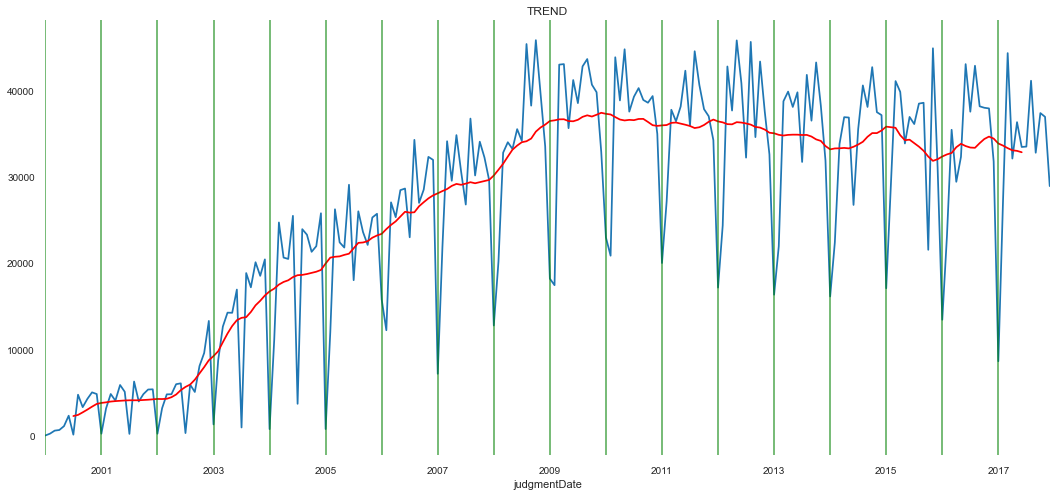

In [263]:
result_YM = seasonal_decompose(dfMonth[field],model='additive')
ax = result.observed.rename('Dados Observados').plot(figsize=(18,8))
result_YM.trend.plot(title='TREND', color='red')


ax.autoscale(axis='x',tight=True)
for x in dfChoosedAnalisys[[field,'month']].query('month==1').index: 
    ax.axvline(x=x, color='green', alpha = 0.6);
   
#result.resid.plot(legend=True);
#seasonal_decompose(dfChoosed.diff()[field].dropna(), model='additive').observed.plot(legend=True)

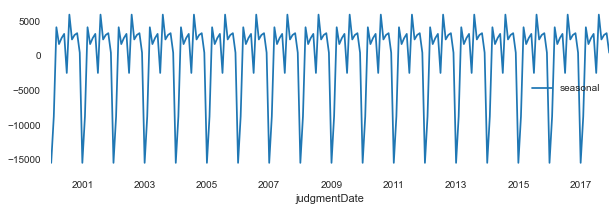

In [264]:
result.seasonal.plot(figsize=(10,3),legend=True);

# Simple Exponential Smoothing

### Exponential Smoothing ocorre sobre dados não estácionarios

In [18]:
dfSimpleExpSmooth = dfChoosed.dropna()
dfSimpleExpSmooth = dfSimpleExpSmooth[[field]]

Index(['total', 'EWMA12', 'SES12', 'DESadd12', 'DESmul12'], dtype='object')
SES12 8146.789424440841
DESadd12 8614.497608377584
DESmul12 6295.996038376754
EWMA12 7943.881107738442


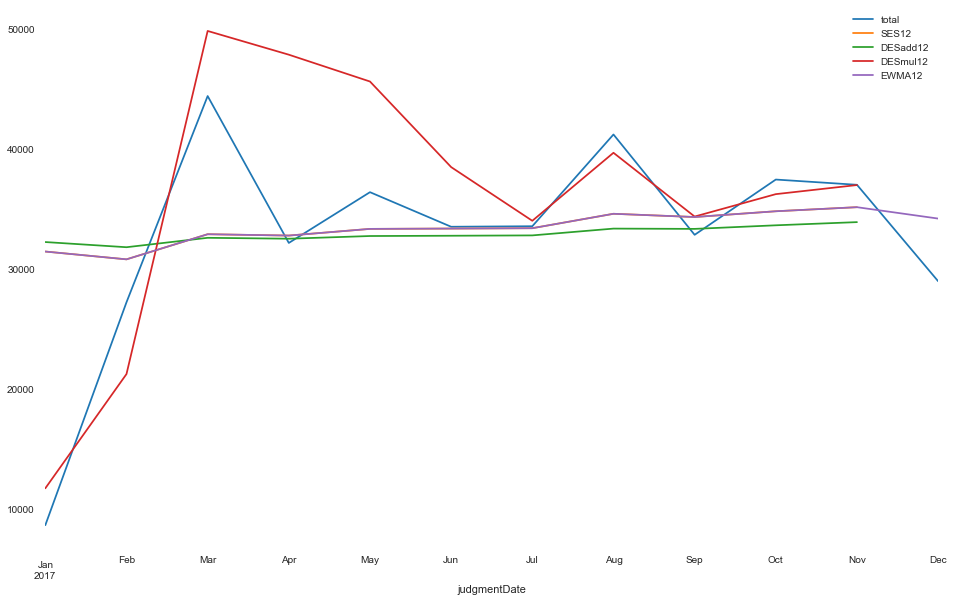

In [19]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


span = predictFieldPeriod
alpha = 2/(span+1)

SimpleExpSmoothFields = [field]


dfSimpleExpSmooth['EWMA'+str(predictFieldPeriod)] = dfSimpleExpSmooth[field].ewm(alpha=alpha,adjust=True).mean()
dfSimpleExpSmooth['SES'+str(predictFieldPeriod)]= SimpleExpSmoothing(dfSimpleExpSmooth[field]).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

dfSimpleExpSmooth['DESadd'+str(predictFieldPeriod)] = ExponentialSmoothing(dfSimpleExpSmooth[field], trend='add').fit().fittedvalues.shift(-1)
try:
    dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)] = ExponentialSmoothing(dfSimpleExpSmooth[field], trend='mul').fit().fittedvalues.shift(-1)
except:
    print('erro mul')
    
print(dfSimpleExpSmooth.columns)
    
dfSimpleExpSmooth[['total', 'SES12', 'DESadd12', 'DESmul12','EWMA12']].tail(12).plot(figsize=(16,10)).autoscale(axis='x',tight=True);



print("SES12",forecast_accuracy(dfSimpleExpSmooth['SES12'][-12:],dfSimpleExpSmooth['total'][-12:])['rmse'])
print("DESadd12",forecast_accuracy(dfSimpleExpSmooth['DESadd12'][-12:],dfSimpleExpSmooth['total'][-12:])['rmse'])
print("DESmul12",forecast_accuracy(dfSimpleExpSmooth['DESmul12'][-12:],dfSimpleExpSmooth['total'][-12:])['rmse'])
print("EWMA12",forecast_accuracy(dfSimpleExpSmooth['EWMA12'][-12:],dfSimpleExpSmooth['total'][-12:])['rmse'])


In [20]:
from colorama import Fore
dfSimpleExpSmooth[field+'_Ant'] = np.where((dfSimpleExpSmooth[field] > dfSimpleExpSmooth[field].shift()),'+',"-")
dfSimpleExpSmooth['EWMA12_Ant'] = np.where((dfSimpleExpSmooth['EWMA12'] > dfSimpleExpSmooth['EWMA12'].shift()),"+","-")
dfSimpleExpSmooth['SES12_Ant'] = np.where((dfSimpleExpSmooth['SES12'] > dfSimpleExpSmooth['SES12'].shift()),"+","-")
dfSimpleExpSmooth['DESadd12_Ant'] = np.where((dfSimpleExpSmooth['DESadd12'] > dfSimpleExpSmooth['DESadd12'].shift()),"+","-")
dfSimpleExpSmooth['DESmul12_Ant'] = np.where((dfSimpleExpSmooth['DESmul12'] > dfSimpleExpSmooth['DESmul12'].shift()),"+","-")
display(dfSimpleExpSmooth['2017':])

total        EWMA12         SES12      DESadd12      DESmul12  \
judgmentDate                                                                  
2017-01-01     8625  31405.625021  31405.625021  32195.598719  11694.015838   
2017-02-01    27182  30755.836557  30755.836557  31765.179648  21205.750478   
2017-03-01    44352  32847.554009  32847.554009  32548.570883  49770.766769   
2017-04-01    32122  32735.930316  32735.930316  32472.988146  47795.464777   
2017-05-01    36348  33291.633344  33291.633344  32697.525927  45561.563266   
2017-06-01    33469  33318.920522  33318.920522  32720.993907  38436.625122   
2017-07-01    33513  33348.778903  33348.778903  32749.247429  33966.110926   
2017-08-01    41151  34549.120610  34549.120610  33315.135738  39627.921123   
2017-09-01    32798  34279.717439  34279.717439  33291.341252  34318.950738   
2017-10-01    37399  34759.607064  34759.607064  33589.964054  36184.756602   
2017-11-01    36963  35098.590593  35098.590593  33854.822554  36941.207505   
2017-12-01    28936  34150.499732           NaN           NaN           NaN   

             total_Ant EWMA12_Ant SES12_Ant DESadd12_Ant DESmul12_Ant  
judgmentDate                                                           
2017-01-01           -          -         -            -            -  
2017-02-01           +          -         -            -            +  
2017-03-01           +          +         +            +            +  
2017-04-01           -          -         -            -            -  
2017-05-01           +          +         +            +            -  
2017-06-01           -          +         +            +            -  
2017-07-01           +          +         +            +            -  
2017-08-01           +          +         +            +            +  
2017-09-01           -          -         -            -            -  
2017-10-01           +          +         +            +            +  
2017-11-01           -          +         +            +            +  
2017-12-01           -          -         -            -            -

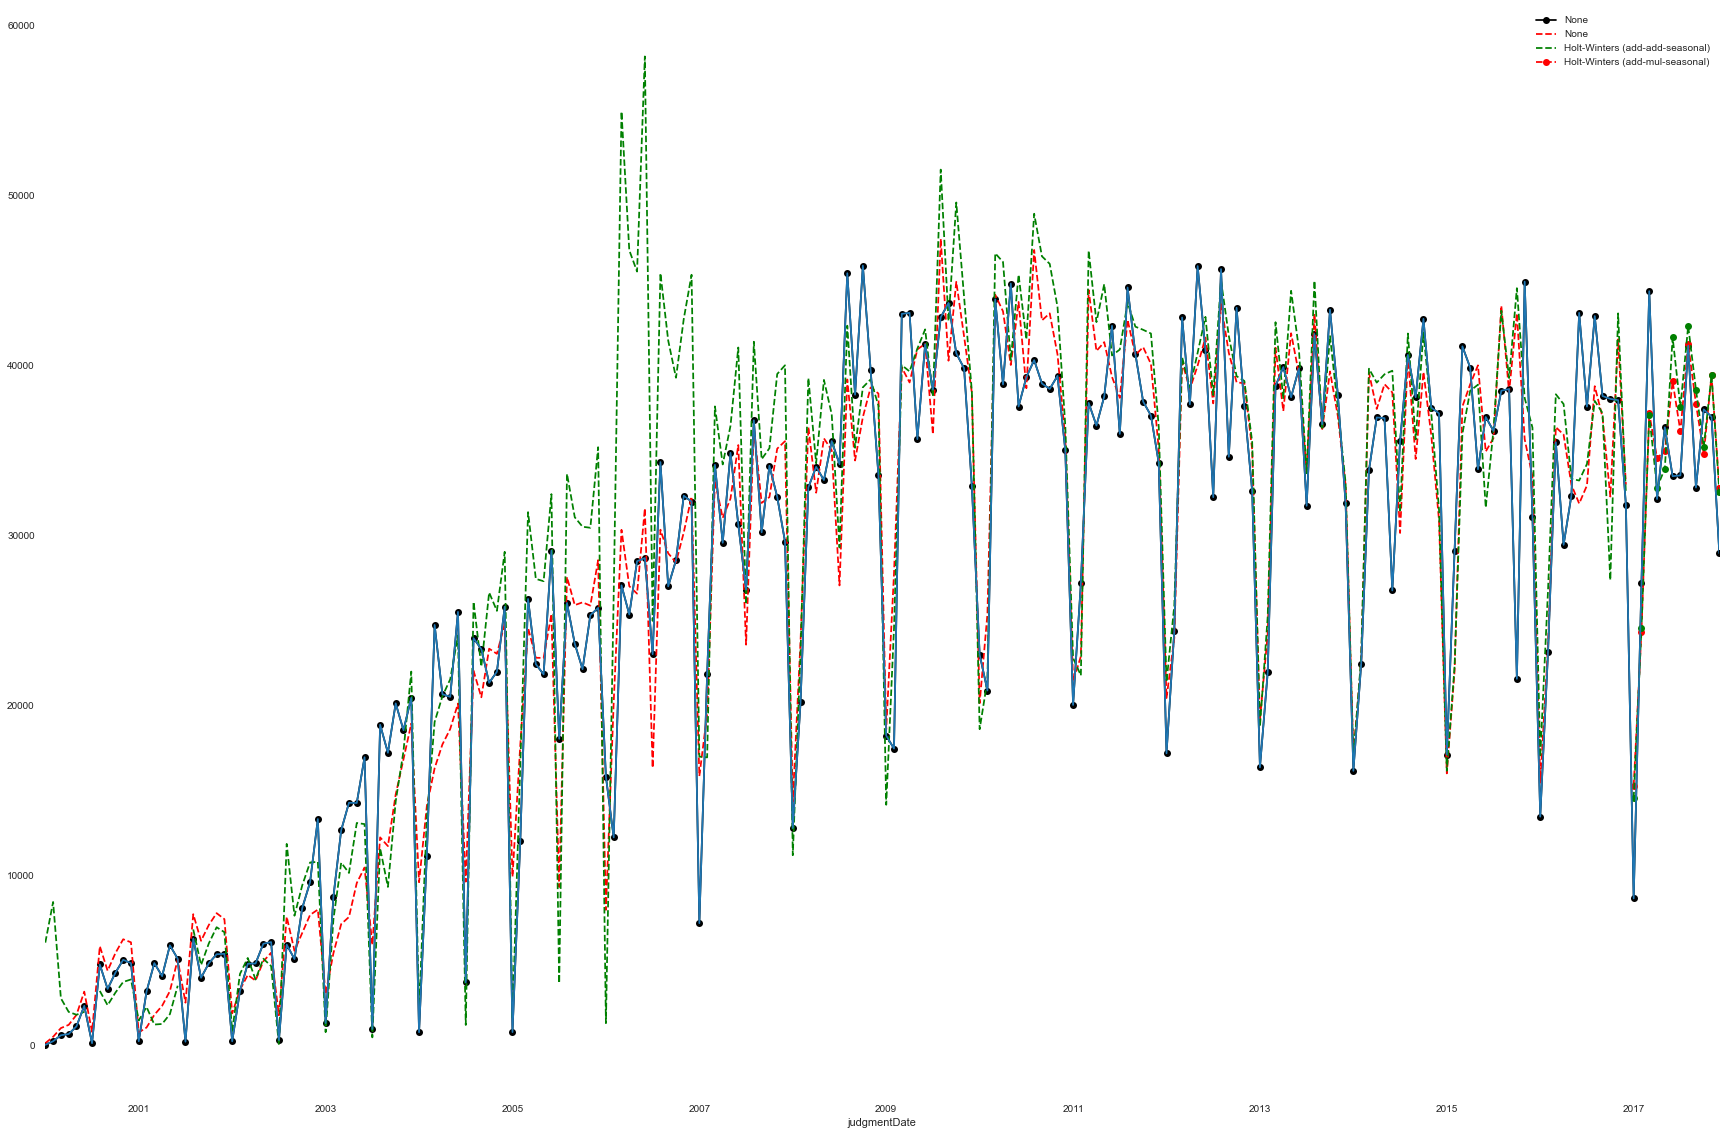

Exponential Smoothing (additional):  6716.590273332058
Exponential Smoothing (multiplicate)  7365.420027868237


In [21]:
dfSimpleExpSmoothTest = dfSimpleExpSmooth.copy()
dfSimpleExpSmoothTest=dfSimpleExpSmoothTest['2000-01-01':'2016-12-31']

fit1 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(dfSimpleExpSmoothTest[field], seasonal_periods=sazonalPeriod, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])

params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = dfSimpleExpSmooth[field].plot(figsize=(30,20), marker='o', color='black')
fit1.fittedvalues.plot(ax=ax, style='--', color='red',legend=True)
fit2.fittedvalues.plot(ax=ax, style='--', color='green',legend=True)
#
fit1.forecast(predictFieldPeriod).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(predictFieldPeriod).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
#
dfChoosed[field].plot()
plt.show()



HwForeCastAdd = fit1.forecast(predictFieldPeriod).rename('Holt-Winters (add-add-seasonal)')
HwForeCastMul = fit2.forecast(predictFieldPeriod).rename('Holt-Winters (add-mul-seasonal)')

display()

print("Exponential Smoothing (additional): ",forecast_accuracy(dfSimpleExpSmooth['DESmul12'][-predictFieldPeriod:],HwForeCastAdd)['rmse'])
print("Exponential Smoothing (multiplicate) ",forecast_accuracy(dfSimpleExpSmooth['DESmul12'][-predictFieldPeriod:],HwForeCastMul)['rmse'])

In [22]:
dfSimpleExpSmooth['DESmul12'][-predictFieldPeriod:]

judgmentDate
2017-01-01    11694.015838
2017-02-01    21205.750478
2017-03-01    49770.766769
2017-04-01    47795.464777
2017-05-01    45561.563266
2017-06-01    38436.625122
2017-07-01    33966.110926
2017-08-01    39627.921123
2017-09-01    34318.950738
2017-10-01    36184.756602
2017-11-01    36941.207505
2017-12-01             NaN
Freq: MS, Name: DESmul12, dtype: float64

In [23]:
train

total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2000-01-01       10               0                     10   
2000-02-01      222             151                     35   
2000-03-01      573             277                     93   
2000-04-01      647             343                    145   
2000-05-01     1096             595                    318   
...             ...             ...                    ...   
2016-08-01    42889           10338                   6848   
2016-09-01    38185            8860                   7263   
2016-10-01    38016            7600                   6484   
2016-11-01    37940            8076                   6499   
2016-12-01    31787            6773                   5493   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2000-01-01                         0              0       0               0   
2000-02-01                         2              0       4               1   
2000-03-01                        30              0      17               5   
2000-04-01                        19              0      18               3   
2000-05-01                        78              0      11               7   
...                              ...            ...     ...             ...   
2016-08-01                      4810           3363    1982            3332   
2016-09-01                      4121           3697    1786            2406   
2016-10-01                      4003           4378    1907            2899   
2016-11-01                      4745           3848    1739            2405   
2016-12-01                      4090           3838    1434            2185   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2000-01-01                0                              0   
2000-02-01                0                             25   
2000-03-01                0                            118   
2000-04-01                2                             89   
2000-05-01                3                             53   
...                     ...                            ...   
2016-08-01             1317                           1351   
2016-09-01             1034                           1096   
2016-10-01             1326                           1025   
2016-11-01             1220                            714   
2016-12-01             1153                            965   

              Reexame Necessário  ...  Medida Cautelar  Desaforamento  \
judgmentDate                      ...                                   
2000-01-01                     0  ...                0              0   
2000-02-01                     1  ...                0              0   
2000-03-01                    21  ...                0              0   
2000-04-01                    14  ...                0              0   
2000-05-01                    16  ...                1              0   
...                          ...  ...              ...            ...   
2016-08-01                   733  ...                1              1   
2016-09-01                   517  ...                0              0   
2016-10-01                   503  ...                0              1   
2016-11-01                   266  ...                1              0   
2016-12-01                   444  ...                0              0   

              Crimes contra a honra  Incidente de Inconstitucionalidade  \
judgmentDate                                                              
2000-01-01                        0                                   0   
2000-02-01                        0                                   0   
2000-03-01                        0                                   0   
2000-04-01                        0            

# Autoregressive Model

In [24]:
dfChoosedAR = dfChoosed.copy()
dfDiffAR = dfDiff.copy()

arTrain=train 
arTest=test

display(dfChoosedAR.head(3))
display(dfDiffAR.head(3))
display(arTrain.head(3))
display(arTest.head(3))

total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2000-01-01       10               0                     10   
2000-02-01      222             151                     35   
2000-03-01      573             277                     93   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2000-01-01                         0              0       0               0   
2000-02-01                         2              0       4               1   
2000-03-01                        30              0      17               5   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2000-01-01                0                              0   
2000-02-01                0                             25   
2000-03-01                0                            118   

              Reexame Necessário  ...  Medida Cautelar  Desaforamento  \
judgmentDate                      ...                                   
2000-01-01                     0  ...                0              0   
2000-02-01                     1  ...                0              0   
2000-03-01                    21  ...                0              0   

              Crimes contra a honra  Incidente de Inconstitucionalidade  \
judgmentDate                                                              
2000-01-01                        0                                   0   
2000-02-01                        0                                   0   
2000-03-01                        0                                   0   

              Impugnação à Assistência Judiciária  \
judgmentDate                                        
2000-01-01                                      0   
2000-02-01                                      0   
2000-03-01                                      0   

              Impugnação ao Valor da Causa  Inquérito Policial  weekDay  \
judgmentDate                                                              
2000-01-01                               0                   0       84   
2000-02-01                               0                   0       85   
2000-03-01                               0                   0       93   

              weekType  Feriado  
judgmentDate                     
2000-01-01          21       29  
2000-02-01          21       29  
2000-03-01          23       31  

[3 rows x 50 columns]

total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2000-02-01    212.0             151                     35   
2000-03-01    351.0             277                     93   
2000-04-01     74.0             343                    145   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2000-02-01                         2              0       4               1   
2000-03-01                        30              0      17               5   
2000-04-01                        19              0      18               3   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2000-02-01                0                             25   
2000-03-01                0                            118   
2000-04-01                2                             89   

              Reexame Necessário  ...  Medida Cautelar  Desaforamento  \
judgmentDate                      ...                                   
2000-02-01                     1  ...                0              0   
2000-03-01                    21  ...                0              0   
2000-04-01                    14  ...                0              0   

              Crimes contra a honra  Incidente de Inconstitucionalidade  \
judgmentDate                                                              
2000-02-01                        0                                   0   
2000-03-01                        0                                   0   
2000-04-01                        0                                   0   

              Impugnação à Assistência Judiciária  \
judgmentDate                                        
2000-02-01                                      0   
2000-03-01                                      0   
2000-04-01                                      0   

              Impugnação ao Valor da Causa  Inquérito Policial  weekDay  \
judgmentDate                                                              
2000-02-01                               0                   0       85   
2000-03-01                               0                   0       93   
2000-04-01                               0                   0       95   

              weekType  Feriado  
judgmentDate                     
2000-02-01          21       29  
2000-03-01          23       31  
2000-04-01          20       29  

[3 rows x 50 columns]

total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2000-01-01       10               0                     10   
2000-02-01      222             151                     35   
2000-03-01      573             277                     93   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2000-01-01                         0              0       0               0   
2000-02-01                         2              0       4               1   
2000-03-01                        30              0      17               5   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2000-01-01                0                              0   
2000-02-01                0                             25   
2000-03-01                0                            118   

              Reexame Necessário  ...  Medida Cautelar  Desaforamento  \
judgmentDate                      ...                                   
2000-01-01                     0  ...                0              0   
2000-02-01                     1  ...                0              0   
2000-03-01                    21  ...                0              0   

              Crimes contra a honra  Incidente de Inconstitucionalidade  \
judgmentDate                                                              
2000-01-01                        0                                   0   
2000-02-01                        0                                   0   
2000-03-01                        0                                   0   

              Impugnação à Assistência Judiciária  \
judgmentDate                                        
2000-01-01                                      0   
2000-02-01                                      0   
2000-03-01                                      0   

              Impugnação ao Valor da Causa  Inquérito Policial  weekDay  \
judgmentDate                                                              
2000-01-01                               0                   0       84   
2000-02-01                               0                   0       85   
2000-03-01                               0                   0       93   

              weekType  Feriado  
judgmentDate                     
2000-01-01          21       29  
2000-02-01          21       29  
2000-03-01          23       31  

[3 rows x 50 columns]

total  Apelação Cível  Agravo de Instrumento  \
judgmentDate                                                 
2017-01-01     8625            1879                   1504   
2017-02-01    27182            5425                   4793   
2017-03-01    44352            8927                   7773   

              Embargos de Declaração  Recurso Cível  Agravo  Apelação Crime  \
judgmentDate                                                                  
2017-01-01                       489            968     147              74   
2017-02-01                      3275           3194    1095            2064   
2017-03-01                      5931           6150    1964            2833   

              Habeas Corpus  Apelação e Reexame Necessário  \
judgmentDate                                                 
2017-01-01              350                            131   
2017-02-01             1496                            554   
2017-03-01             1737                            839   

              Reexame Necessário  ...  Medida Cautelar  Desaforamento  \
judgmentDate                      ...                                   
2017-01-01                    93  ...                0              0   
2017-02-01                   471  ...                1              0   
2017-03-01                   589  ...                1              1   

              Crimes contra a honra  Incidente de Inconstitucionalidade  \
judgmentDate                                                              
2017-01-01                        0                                   0   
2017-02-01                        0                                   1   
2017-03-01                        0                                   0   

              Impugnação à Assistência Judiciária  \
judgmentDate                                        
2017-01-01                                      0   
2017-02-01                                      0   
2017-03-01                                      0   

              Impugnação ao Valor da Causa  Inquérito Policial  weekDay  \
judgmentDate                                                              
2017-01-01                               0                   0       91   
2017-02-01                               0                   0       84   
2017-03-01                               0                   0       93   

              weekType  Feriado  
judgmentDate                     
2017-01-01          22       30  
2017-02-01          20       28  
2017-03-01          23       31  

[3 rows x 50 columns]

AR(1) : 10398.242815089487
AR(2) : 9829.334766934815
AR(14) : 5102.92188757745


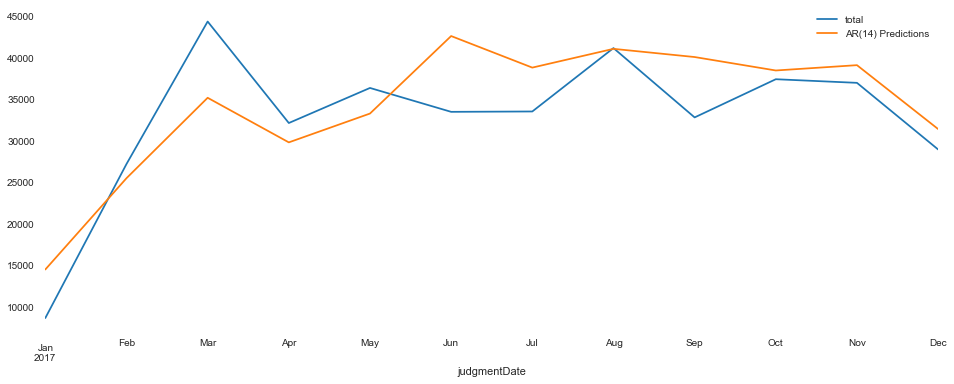

In [25]:
from statsmodels.tsa.ar_model import AR,ARResults

modelArima = AR(arTrain[field])
modelArima2 = AR(arTrain[field])
modelArima3 = AR(arTrain[field])


AR1fit = modelArima.fit(maxlag=1,method='cmle')
AR2fit = modelArima2.fit(maxlag=2,method='cmle')
AR3fit = modelArima3.fit(maxlag=14,method='cmle')

start=len(arTrain)
end=len(arTrain)+len(arTest)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')
rename = f'AR({AR3fit.k_ar}) Predictions'
predictions11 = AR3fit.predict(start=start,end=end,dynamic=False).rename( f'AR({AR3fit.k_ar}) Predictions')

arTest[field].plot(legend=True)
#predictions1.plot(legend=True)
#predictions2.plot(legend=True)
predictions11.plot(legend=True,figsize=(16,6));

from sklearn.metrics import mean_squared_error
labelsAR = ['AR(1)','AR(2)',f'AR({AR3fit.k_ar})']
ArimaPreds = [predictions1, predictions2, predictions11]  # these are variables, not strings!
ArimaPredsResult = []

for i in range(3):
    print(labelsAR[i],':',forecast_accuracy(arTest[field], ArimaPreds[i])['rmse'])
    #ArimaPredsResult.append(forecast_accuracy(arTest[field], ArimaPreds[i])['rmse'])




In [26]:
#display(arTest[[field]])
#display(pd.DataFrame(predictions1))
dfARIMACompareResult= arTest[[field]].join(pd.DataFrame(predictions1)).join(pd.DataFrame(predictions2)).join(pd.DataFrame(predictions11))
dfARIMACompareResult.columns = [field,'AR','AR1','AR14']
dfARIMACompareResult[field+'_Ant'] = np.where((dfARIMACompareResult[field] > dfARIMACompareResult[field].shift()),"+","-")
dfARIMACompareResult['AR_Ant'] = np.where((dfARIMACompareResult['AR'] > dfARIMACompareResult['AR'].shift()),"+","-")
dfARIMACompareResult['AR1_Ant'] = np.where((dfARIMACompareResult['AR1'] > dfARIMACompareResult['AR1'].shift()),"+","-")
dfARIMACompareResult['AR14_Ant'] = np.where((dfARIMACompareResult['AR14'] > dfARIMACompareResult['AR14'].shift()),"+","-")
dfARIMACompareResult

total            AR           AR1          AR14 total_Ant  \
judgmentDate                                                              
2017-01-01     8625  30765.138283  32300.603364  14474.178099         -   
2017-02-01    27182  29938.278111  31358.710240  25473.303646         +   
2017-03-01    44352  29269.207403  30864.955077  35164.059266         +   
2017-04-01    32122  28727.815244  30356.358164  29789.771026         -   
2017-05-01    36348  28289.736779  29930.728145  33263.944931         +   
2017-06-01    33469  27935.256687  29554.859661  42601.866615         -   
2017-07-01    33513  27648.421919  29227.782318  38798.922651         +   
2017-08-01    41151  27416.323738  28942.030605  41060.213526         +   
2017-09-01    32798  27228.516778  28692.651366  40072.849013         -   
2017-10-01    37399  27076.548961  28474.951537  38452.613337         +   
2017-11-01    36963  26953.581114  28284.921747  39093.204638         -   
2017-12-01    28936  26854.079183  28119.041551  31394.962614         -   

             AR_Ant AR1_Ant AR14_Ant  
judgmentDate                          
2017-01-01        -       -        -  
2017-02-01        -       -        +  
2017-03-01        -       -        +  
2017-04-01        -       -        -  
2017-05-01        -       -        +  
2017-06-01        -       -        +  
2017-07-01        -       -        -  
2017-08-01        -       -        +  
2017-09-01        -       -        -  
2017-10-01        -       -        -  
2017-11-01        -       -        +  
2017-12-01        -       -        -

# CMLE foi melhor do que MLE

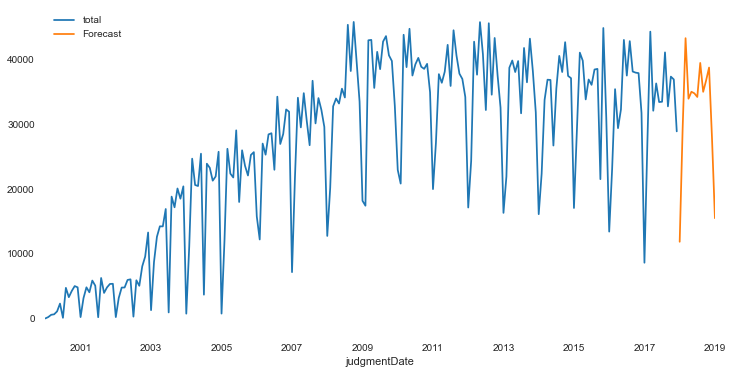

In [31]:
modelARForecast = AR(dfChoosedAR[field])
ARfitForecast = modelARForecast.fit(maxlag=AR3fit.k_ar,method='cmle')
# Make predictions
fcastAR = ARfitForecast.predict(start=len(dfChoosedAR), end=len(dfChoosedAR)+predictFieldPeriod, dynamic=False).rename('Forecast')
dfChoosedAR[field].plot(legend=True)
fcastAR.plot(legend=True,figsize=(12,6));

# Tests for Stationarity

A time series is stationary if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is not stationary.

A test for stationarity usually involves a unit root hypothesis test, where the null hypothesis  𝐻0  is that the series is nonstationary, and contains a unit root. The alternate hypothesis  𝐻1  supports stationarity. The augmented Dickey-Fuller and Kwiatkowski-Phillips-Schmidt-Shin tests are stationarity tests.

## Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

To demonstrate, we'll use a dataset we know is <em>not</em> stationary, the airline_passenger dataset. First, let's plot the data along with a 12-month rolling mean and standard deviation:

(0.10219011015738777, '', -2.5571079596619577, 14, 201, {'1%': -3.4633090972761744, '5%': -2.876029332045744, '10%': -2.5744932593252643}, 3953.4211936388106, 'Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary')
(0.005359290063266703, '', -3.6217099251587053, 15, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 3939.1954624144064, 'Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary')
total


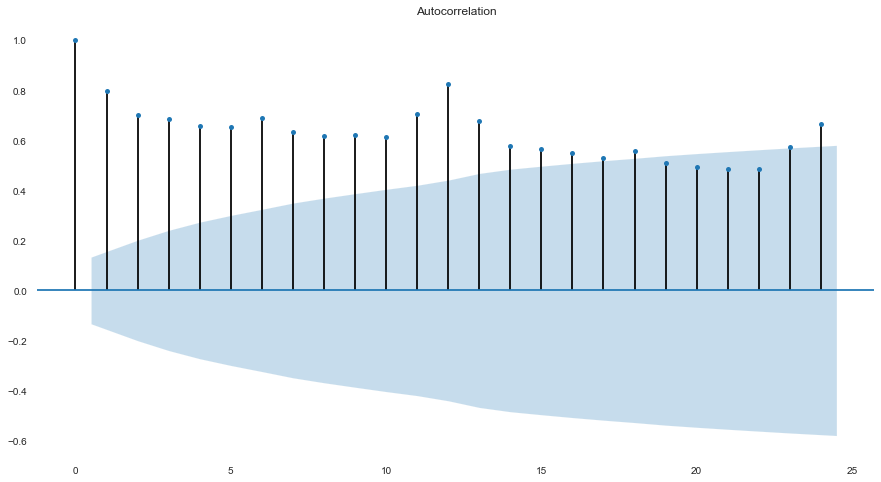

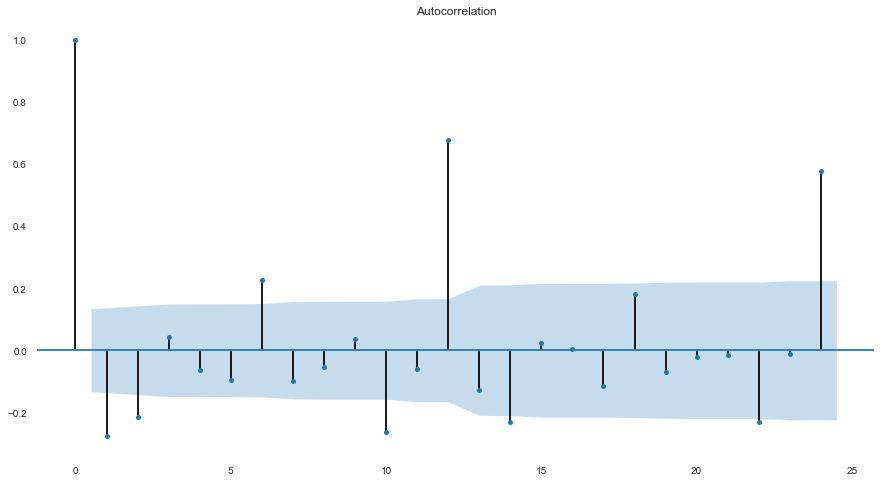

In [32]:
#adf_teste(dfChoosed[field])
print(adf_teste(dfChoosed[field]))
print(adf_teste(dfDiff[field]))
print(field)

plot_acf(dfChoosed[[field]]);
plot_acf(dfDiff[[field]]);

## TESTANDO SAZONALIDADE COM GRAFICO

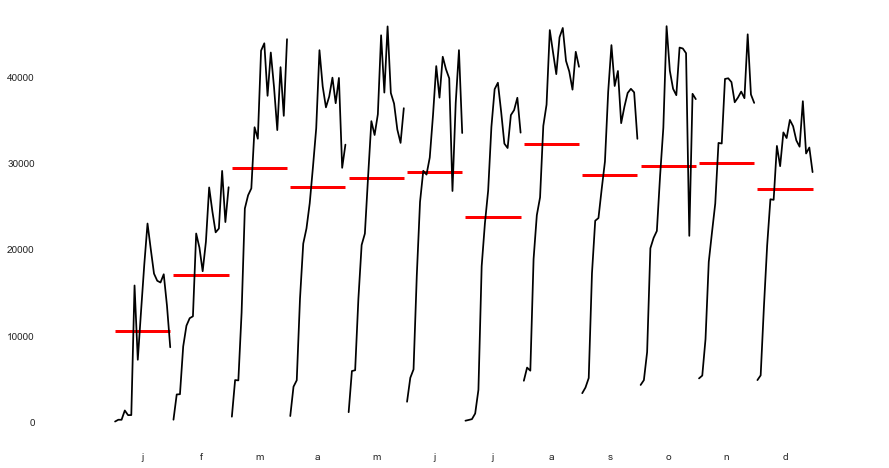

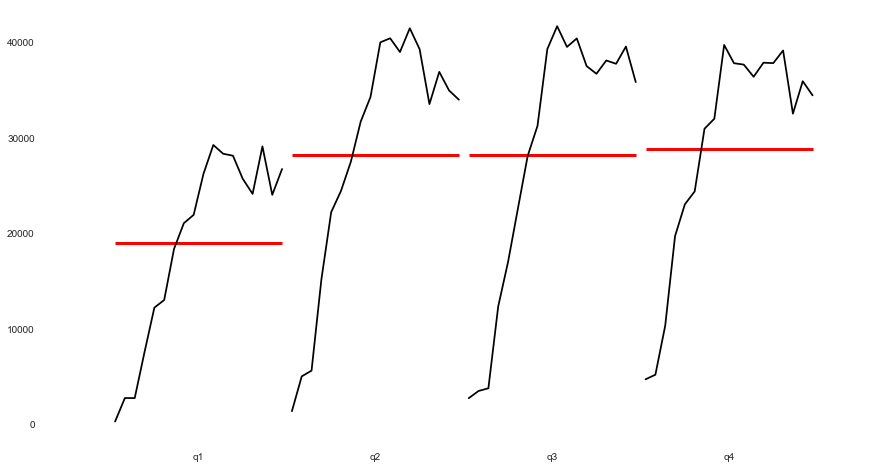

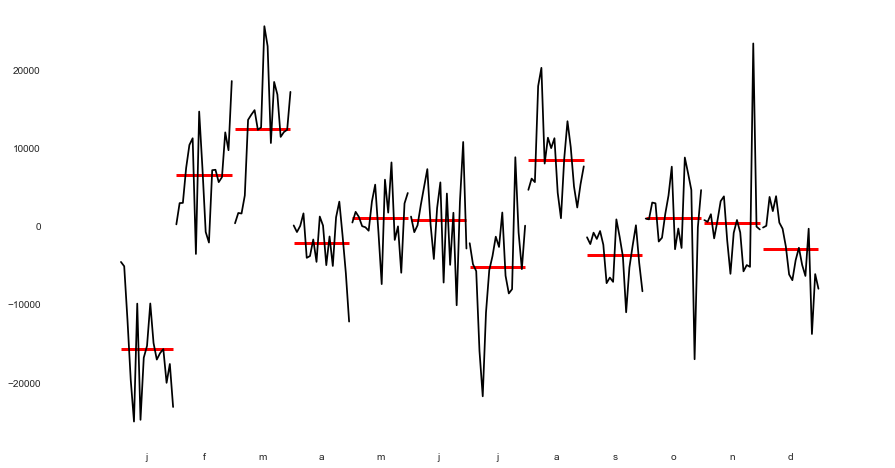

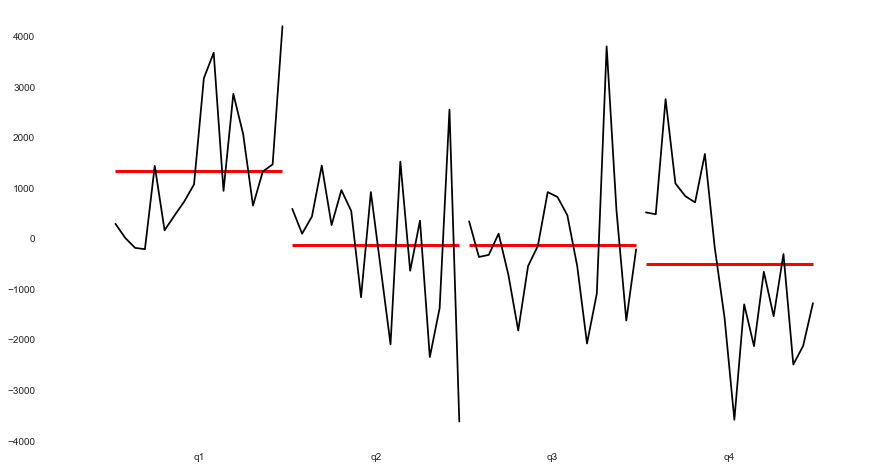

In [33]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
month_plot(dfChoosed[field]);

dfq = dfChoosed[field].resample(rule='Q').mean()
quarter_plot(dfq);
month_plot(dfDiff[field]);
dfq = dfDiff[field].resample(rule='Q').mean()
quarter_plot(dfq);

# ANALISE SARIMA

NameError: name 'predictionsARMA' is not defined

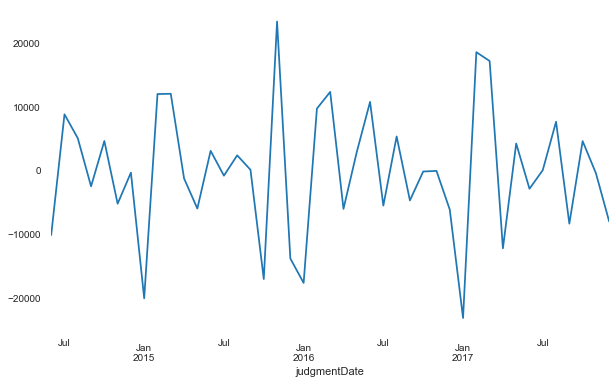

In [34]:
dfSarimaAnalise = testDiff.copy()
dfSarimaAnalise['month'] = dfSarimaAnalise.index.month
dfSarimaAnalise['year'] = dfSarimaAnalise.index.year



axx = dfSarimaAnalise[field].plot(figsize=(10,6))
predictionsARMA.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax = result.observed.rename('Dados Observados').plot(figsize=(18,8))
#ax.autoscale(axis='x',tight=True)
for x in dfSarimaAnalise[[field,'month','year']].query('month==6 and year==2016').index: 
    axx.axvline(x=x, color='green', alpha = 0.6,linestyle=':');
for x in dfSarimaAnalise[[field,'month','year']].query('(month==11 or month==6 or month==10) and year==2015').index: 
    axx.axvline(x=x, color='green', alpha = 0.6,linestyle=':');
for x in dfSarimaAnalise[[field,'month','year']].query('month==12 and year==2014').index: 
    axx.axvline(x=x, color='green', alpha = 0.6,linestyle=':');


# ARIMA com AUTO.ARIMA

In [35]:
auto_arima(train[field],seasonal=True,m=predictFieldPeriod).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  204
Model:             SARIMAX(3, 1, 3)x(2, 0, [], 12)   Log Likelihood               -1996.119
Date:                             Thu, 04 Jun 2020   AIC                           4012.237
Time:                                     16:14:54   BIC                           4045.369
Sample:                                          0   HQIC                          4025.641
                                             - 204                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    206.9147    204.652      1.011      0.312    -194.196     608.025
ar.L1         -1.9038      0.110    -17.240      0.000      -2.120      -1.687
ar.L2         -1.3579      0.131    -10.405      0.000      -1.614      -1.102
ar.L3         -0.2211      0.079     -2.792      0.005      -0.376      -0.066
ma.L1          0.8987      0.099      9.083      0.000       0.705       1.093
ma.L2         -0.3665      0.108     -3.397      0.001      -0.578      -0.155
ma.L3         -0.8030      0.066    -12.246      0.000      -0.932      -0.674
ar.S.L12       0.4270      0.059      7.223      0.000       0.311       0.543
ar.S.L24       0.4262      0.063      6.755      0.000       0.303       0.550
sigma2      1.721e+07   1.16e-07   1.48e+14      0.000    1.72e+07    1.72e+07
===================================================================================
Ljung-Box (Q):                       46.73   Jarque-Bera (JB):                65.98
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                            -0.55
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+35. Standard errors may be unstable.
"""

<hr>
<h1 style="color:red"> VERIFICAR RETORNO DO MODELO </h1>
<hr>

## RETORNOU PARA USO SARIMAX

In [36]:
#ARIMAauto_arimaNoDiff = auto_arima(train[field],seasonal=True,stationary=True,m=12)
ARIMAauto_arimaNoDiff = auto_arima(train[field],seasonal=True,stationary=False,m=12)
ARIMAauto_arimaNoDiff

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(2, 0, 0, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [37]:
modelARMANoDiff = SARIMAX(train[field],order=ARIMAauto_arimaNoDiff.order,seasonal_order=ARIMAauto_arimaNoDiff.seasonal_order)
resultARMANoDiff = modelARMANoDiff.fit()
resultARMANoDiff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  204
Model:             SARIMAX(3, 1, 3)x(2, 0, [], 12)   Log Likelihood               -2035.036
Date:                             Thu, 04 Jun 2020   AIC                           4088.071
Time:                                     16:15:47   BIC                           4117.890
Sample:                                 01-01-2000   HQIC                          4100.135
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2939      0.392      0.749      0.454      -0.475       1.062
ar.L2         -0.6973      0.393     -1.774      0.076      -1.468       0.073
ar.L3         -0.0010      0.270     -0.004      0.997      -0.531       0.529
ma.L1         -1.1689      0.353     -3.313      0.001      -1.860      -0.477
ma.L2          1.1356      0.459      2.472      0.013       0.235       2.036
ma.L3         -0.7666      0.242     -3.169      0.002      -1.241      -0.292
ar.S.L12       0.5335      0.197      2.714      0.007       0.148       0.919
ar.S.L24       0.2437      0.206      1.182      0.237      -0.160       0.648
sigma2      5.621e+07   1.19e-08   4.71e+15      0.000    5.62e+07    5.62e+07
===================================================================================
Ljung-Box (Q):                       31.52   Jarque-Bera (JB):                52.80
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -0.57
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+31. Standard errors may be unstable.
"""

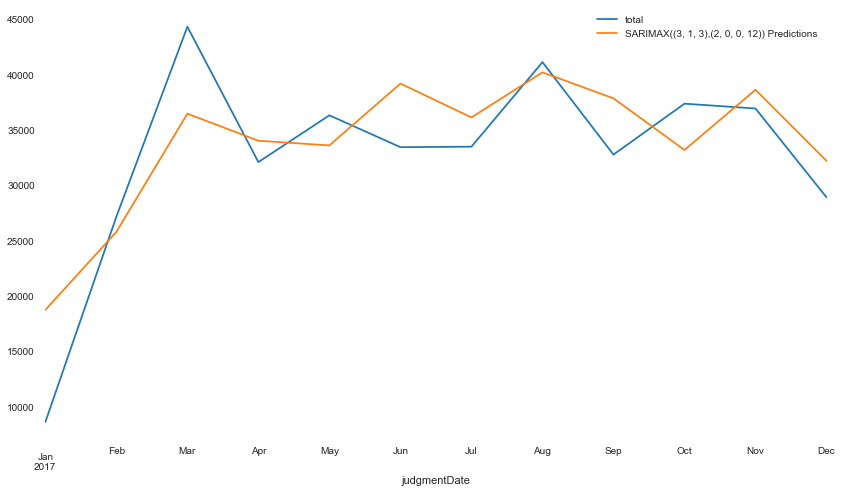

12 12
SARIMAX:                                 4790.366029949612


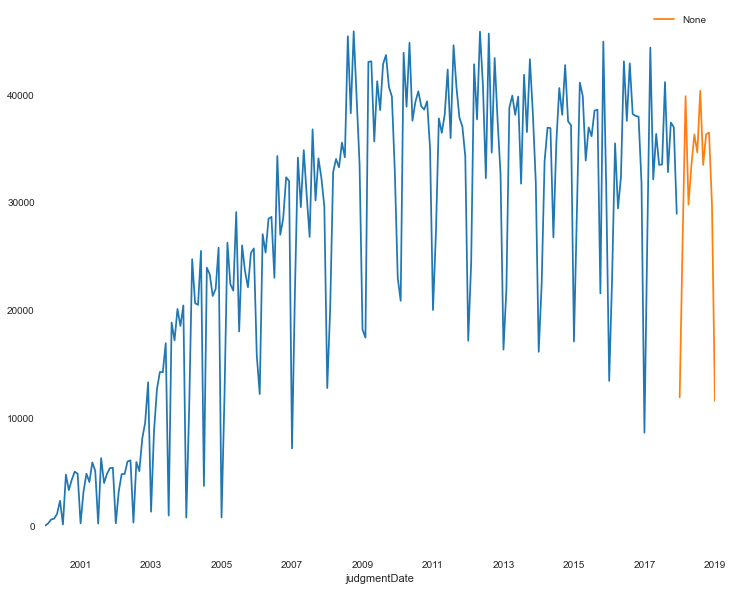

In [38]:
start=len(train)
end=len(train)+len(test) - 1

predictionsARMANodiff = resultARMANoDiff.predict(start=start, end=end).rename(f'SARIMAX({ARIMAauto_arimaNoDiff.order},{ARIMAauto_arimaNoDiff.seasonal_order}) Predictions')
ax = test[field].plot(legend=True,figsize=(14,8))
predictionsARMANodiff.plot(legend=True)
ax.autoscale(axis='x',tight=True)
plt.show()
print(len(test[field]),len(predictionsARMANodiff))
print(adjust('SARIMAX: ',40),forecast_accuracy(test[field], predictionsARMANodiff)['rmse'])

#display(predictionsARMANodiff.order)

#prevendo sobre o dataset
modelARMANoDiff = SARIMAX(dfChoosed[[field]],order=ARIMAauto_arimaNoDiff.order,seasonal_order=ARIMAauto_arimaNoDiff.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
resultsForeCastARIMANoDiff = modelARMANoDiff.fit()
fcastARIMANoDiff = resultsForeCastARIMANoDiff.predict(len(dfChoosed),len(dfChoosed)+predictFieldPeriod,type='levels')
dfChoosed[field].plot(figsize=(12,10))
fcastARIMANoDiff.plot(legend=True)


In [39]:
# TESTE SEM SAZONALIDADE

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)


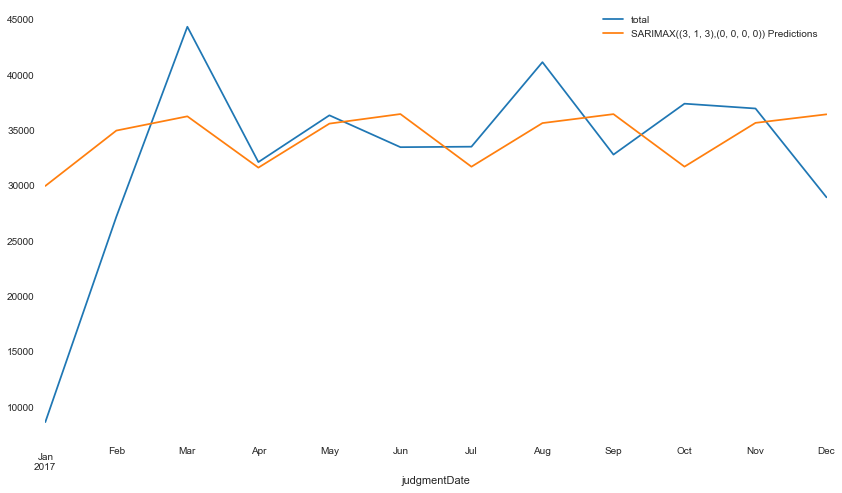

12 12
SARIMAX:                                 7792.2318855165395


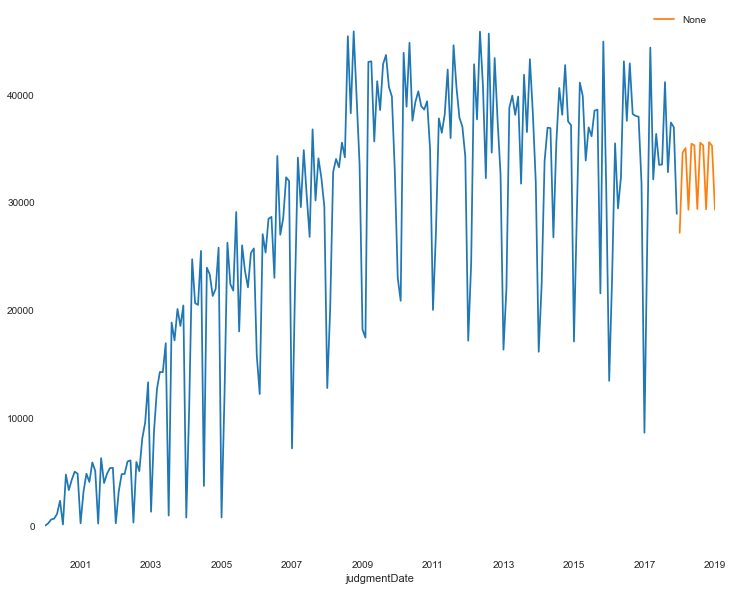

In [40]:
ARIMAauto_arimaNoSeas = auto_arima(train[field])#,seasonal=True,stationary=False,m=12)
print(ARIMAauto_arimaNoSeas)

modelARMANoDiffNoSeas = SARIMAX(train[field],order=ARIMAauto_arimaNoSeas.order,seasonal_order=ARIMAauto_arimaNoSeas.seasonal_order)
resultARMANoSeas = modelARMANoDiffNoSeas.fit()

start=len(train)
end=len(train)+len(test) - 1

predictionsARMANoSeas = resultARMANoSeas.predict(start=start, end=end).rename(f'SARIMAX({ARIMAauto_arimaNoSeas.order},{ARIMAauto_arimaNoSeas.seasonal_order}) Predictions')
ax = test[field].plot(legend=True,figsize=(14,8))
predictionsARMANoSeas.plot(legend=True)
ax.autoscale(axis='x',tight=True)
plt.show()
print(len(test[field]),len(predictionsARMANoSeas))
print(adjust('SARIMAX: ',40),forecast_accuracy(test[field], predictionsARMANoSeas)['rmse'])

#display(predictionsARMANodiff.order)

#prevendo sobre o dataset
modelARMANoSeas = SARIMAX(dfChoosed[[field]],order=ARIMAauto_arimaNoSeas.order,seasonal_order=ARIMAauto_arimaNoSeas.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
resultsForeCastARIMANoSeas = modelARMANoSeas.fit()
fcastARIMANoSeas = resultsForeCastARIMANoSeas.predict(len(dfChoosed),len(dfChoosed)+predictFieldPeriod,type='levels')
dfChoosed[field].plot(figsize=(12,10))
fcastARIMANoSeas.plot(legend=True)

#resultARMANoSeasmary()

ARIMA(maxiter=50, method='lbfgs', order=(4, 0, 5), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)


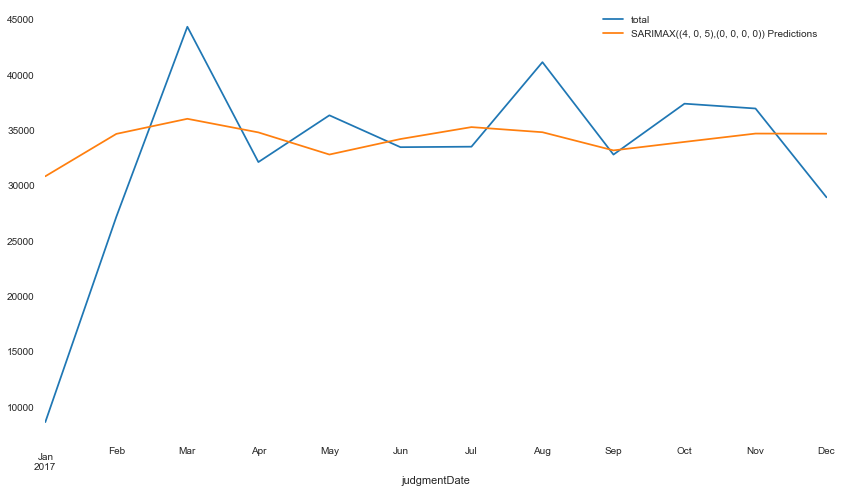

12 12
SARIMAX:                                 7812.928495896431


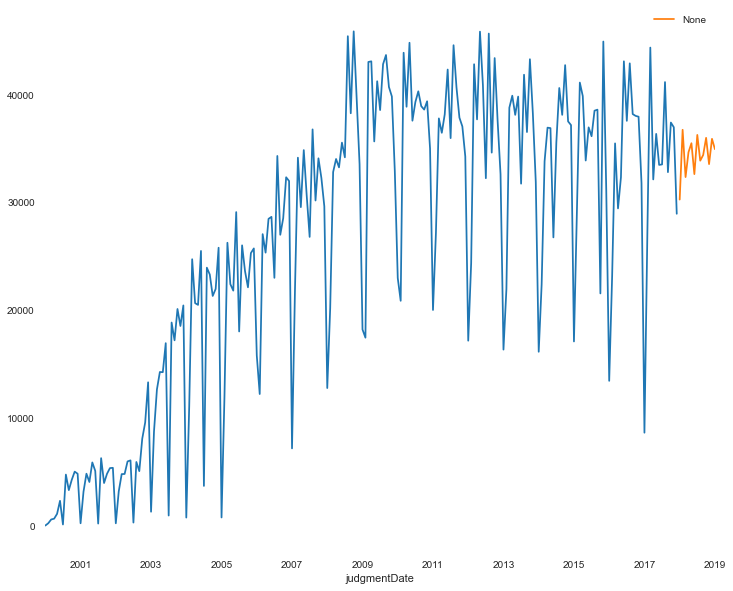

In [41]:
ARIMAauto_arimaNoSeas = auto_arima(train[field],stationary=True)#,seasonal=True)#,m=12)
print(ARIMAauto_arimaNoSeas)

modelARMANoDiffNoSeas = SARIMAX(train[field],order=ARIMAauto_arimaNoSeas.order,seasonal_order=ARIMAauto_arimaNoSeas.seasonal_order)
resultARMANoSeas = modelARMANoDiffNoSeas.fit()

start=len(train)
end=len(train)+len(test) - 1

predictionsARMANoSeas = resultARMANoSeas.predict(start=start, end=end).rename(f'SARIMAX({ARIMAauto_arimaNoSeas.order},{ARIMAauto_arimaNoSeas.seasonal_order}) Predictions')
ax = test[field].plot(legend=True,figsize=(14,8))
predictionsARMANoSeas.plot(legend=True)
ax.autoscale(axis='x',tight=True)
plt.show()
print(len(test[field]),len(predictionsARMANoSeas))
print(adjust('SARIMAX: ',40),forecast_accuracy(test[field], predictionsARMANoSeas)['rmse'])

#display(predictionsARMANodiff.order)

#prevendo sobre o dataset
modelARMANoSeas = SARIMAX(dfChoosed[[field]],order=ARIMAauto_arimaNoSeas.order,seasonal_order=ARIMAauto_arimaNoSeas.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
resultsForeCastARIMANoSeas = modelARMANoSeas.fit()
fcastARIMANoSeas = resultsForeCastARIMANoSeas.predict(len(dfChoosed),len(dfChoosed)+predictFieldPeriod,type='levels')
dfChoosed[field].plot(figsize=(12,10))
fcastARIMANoSeas.plot(legend=True)

In [42]:
dfTesteSeasonalDecompose = seasonal_decompose(data[field][-360:],model='mul',extrapolate_trend='freq').seasonal[-14:].to_frame()
dfTesteSeasonalDecompose['2'] = seasonal_decompose(data[field][-360:],model='mul',extrapolate_trend=12).seasonal[-14:].to_frame()
dfTesteSeasonalDecompose['3'] = seasonal_decompose(data[field][-360:],model='mul',extrapolate_trend=24).seasonal[-14:].to_frame()
dfTesteSeasonalDecompose['4'] = seasonal_decompose(data[field][-360:],model='mul',two_sided=True,extrapolate_trend=24).seasonal[-14:].to_frame()
dfTesteSeasonalDecompose['5'] = seasonal_decompose(data[field][-360:],model='mul',two_sided=False,extrapolate_trend=24).seasonal[-14:].to_frame()
dfTesteSeasonalDecompose

NameError: name 'data' is not defined

In [ ]:
display()
display()

# APLICANDO EXOGENOUS DATA 

### Teoria: ARMA

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

#data = trainDiff.copy()
data = train.copy()
#display(data.head(2))

# Dados sao estacionarios devido ao diff ja feito, portanto modelo deve ser add 
result_mul = seasonal_decompose(data[field],model='mul',extrapolate_trend='freq',two_sided=True) 

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month
seasonal_index.head(2)

#merge with the base data
data['month'] = data.index.month
dfSeasonalDiff = pd.merge(data, seasonal_index, how='left', on='month')
dfSeasonalDiff.index = data.index
display(dfSeasonalDiff.tail(6))



#display(df.head(20))

<hr>
<h1 style="color:red"> VERIFICAR RETORNO DO MODELO </h1>
<hr>

## RETORNOU PARA USO SARIMAX

In [ ]:
ARIMAauto_arimaExog = auto_arima(train[[field]],seasonal=True,m=12,exogenous=dfSeasonalDiff[['seasonal']])
ARIMAauto_arimaExog

modelARMAExog = SARIMAX(train[field],order=ARIMAauto_arimaExog.order,seasonal_order=ARIMAauto_arimaExog.seasonal_order)
resultARMAExog = modelARMAExog.fit()
resultARMAExog.summary()

start=len(train)
end=len(train)+len(test)-1

predictionsARMAExog = resultARMAExog.predict(start=start, end=end,exogenous=np.tile(dfSeasonalDiff['seasonal'].values, 2)).rename(f'SARIMAX({ARIMAauto_arima.order},{ARIMAauto_arima.seasonal_order}) Exogenous Predictions')
ax = test[field].plot(legend=True,figsize=(14,8))
predictionsARMAExog.plot(legend=True)
ax.autoscale(axis='x',tight=True)
plt.show()
print(adjust('SARIMAX: ',40),forecast_accuracy(test[field], predictionsARMAExog)['rmse'])


modelARIMAExog = SARIMAX(dfChoosed[field],order=ARIMAauto_arimaExog.order,seasonal_order=ARIMAauto_arimaExog.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
resultsForeCastARIMAExog = modelARIMAExog.fit()
fcastARIMAExog = resultsForeCastARIMAExog.predict(len(dfChoosed),len(dfChoosed)+predictFieldPeriod,type='levels')
dfChoosed[field].plot(figsize=(12,10))
fcastARIMAExog.rename('SARIMAX FORECAST Exog').plot(legend=True)

#4782

# PYTHON ACESSANDO R

In [ ]:
import rpy2
print(rpy2.__version__)
from rpy2.robjects import default_converter,pandas2ri,r
from rpy2.robjects.conversion import Converter, localconverter
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

base = importr('nnet')
base = importr('forecast')
base = importr('base')
utils = importr('utils')
jurimetrics = importr('jurimetrics')
ts=robjects.r('ts')
pandas2ri.activate()

In [ ]:
rdataAll = ts((dfChoosed[field]),frequency=12)
rdataTrain = ts((dfChoosed[field][:-predictFieldPeriod]),frequency=12)
rdataTest = ts((dfChoosed[field][-predictFieldPeriod:]),frequency=12)

print(len(rdataTrain))
print(len(rdataTest))

In [ ]:
d = pd.date_range(start='2000-01-01', end='2030-12-01', freq='MS')   


frequence = ''

if dfChoosed[field]['2016'].count() == 12:
    frequence = 'MS'

if dfChoosed[field]['2016'].count() == 4:
    frequence = 'QS'
    
if dfChoosed[field]['2016'].count() == 1:
    frequence = 'A'
    
robjects.globalenv['r_timeseriesTrain'] = rdataTrain
robjects.globalenv['r_timeseriesAll'] = rdataAll

# NNETAR

In [ ]:
pred2NNETAR = robjects.r('(forecast::nnetar(r_timeseriesTrain))')
fcastNNetar = robjects.r('as.data.frame(forecast::forecast(forecast::nnetar(r_timeseriesTrain),h='+str(predictFieldPeriod)+'))')

fcastFutureNNetar = robjects.r('as.data.frame(forecast::forecast(forecast::nnetar(r_timeseriesAll),h='+str(predictFieldPeriod)+'))')

dfR = pd.DataFrame(pd.Series(d[0:len(pred2NNETAR[9])]))
dfNNetarFC = pd.DataFrame(pd.Series(d[len(pred2NNETAR[9]):len(pred2NNETAR[9])+predictFieldPeriod]))
dfNNetarFCFuture = pd.DataFrame(pd.Series(d[len(rdataAll):len(rdataAll)+predictFieldPeriod]))


dfR[field] = pd.Series(pred2NNETAR[9]).values
dfNNetarFC[field] = fcastNNetar.values
dfNNetarFCFuture[field] = fcastFutureNNetar.values

dfR.columns=['date',field]
dfR.index = pd.to_datetime(dfR['date'])
dfR.freq = frequence
dfR = dfR[[field]]

dfNNetarFC.columns=['date',field]
dfNNetarFC.index = pd.to_datetime(dfNNetarFC['date'])
dfNNetarFC.freq = frequence
dfNNetarFC = dfNNetarFC[[field]]

dfNNetarFCFuture.columns=['date',field]
dfNNetarFCFuture.index = pd.to_datetime(dfNNetarFCFuture['date'])
dfNNetarFCFuture.freq = frequence
dfNNetarFCFuture = dfNNetarFCFuture[[field]]

dfR.plot(legend=True,figsize=figsize)
dfChoosed[field].plot(legend=True)
dfNNetarFC[field].plot(legend=True)
dfNNetarFCFuture[field].plot(legend=True)

print(len(rdataTest),len(dfNNetarFC[field].values))
print(adjust('NNETAR: ',40), forecast_accuracy(rdataTest,dfNNetarFC[field].values)['rmse'])


12 12
ETS:                                     9420.611175424645


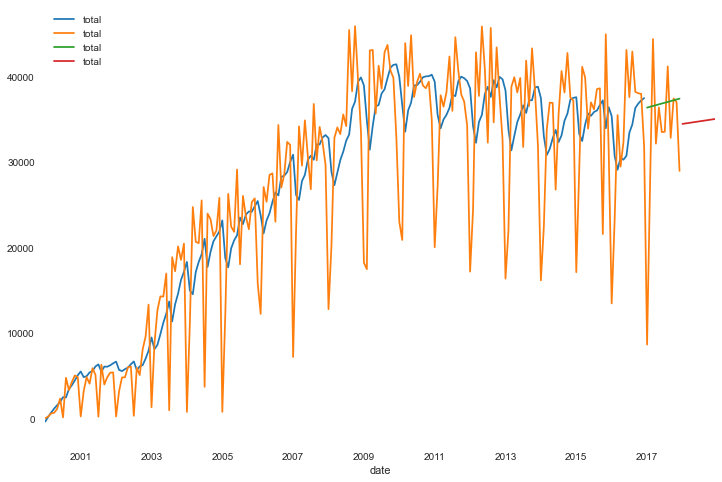

In [49]:
pred2ETS = robjects.r('(forecast::ets(r_timeseriesTrain))')
fcastETS = robjects.r('as.data.frame(forecast::forecast(forecast::ets(r_timeseriesTrain),h='+str(predictFieldPeriod)+'))')
fcastFutureETS = robjects.r('as.data.frame(forecast::forecast(forecast::ets(r_timeseriesAll),h='+str(predictFieldPeriod)+'))')

predETS = pred2ETS[8]#[:,0]

dfRETS = pd.DataFrame(pd.Series(d[0:len(predETS)]))
dfETSFC = pd.DataFrame(pd.Series(d[len(predETS):len(predETS)+predictFieldPeriod]))
dfETSFuture = pd.DataFrame(pd.Series(d[len(rdataAll):len(rdataAll)+predictFieldPeriod]))

coluna = fcastETS.columns[0]

dfRETS[field] = pd.DataFrame(pd.Series(predETS))
dfETSFC[field] = fcastETS[coluna].values
dfETSFuture[field] = fcastFutureETS[coluna].values

dfRETS.columns=['date',field]
dfRETS.index = pd.to_datetime(dfRETS['date'])
dfRETS.freq = frequence
dfRETS = dfRETS[[field]]

dfETSFC.columns=['date',field]
dfETSFC.index = pd.to_datetime(dfETSFC['date'])
dfETSFC.freq = frequence
dfETSFC = dfETSFC[[field]]

dfETSFuture.columns=['date',field]
dfETSFuture.index = pd.to_datetime(dfETSFuture['date'])
dfETSFuture.freq = frequence
dfETSFuture = dfETSFuture[[field]]

dfRETS.plot(legend=True,figsize=figsize)
dfChoosed[field].plot(legend=True)
dfETSFC[field].plot(legend=True)
dfETSFuture[field].plot(legend=True)

print(len(rdataTest),len(dfETSFC[field].values))
print(adjust('ETS: ',40), forecast_accuracy(rdataTest,dfETSFC[field].values)['rmse'])


12 12
TBATS:                                   8426.752907262886


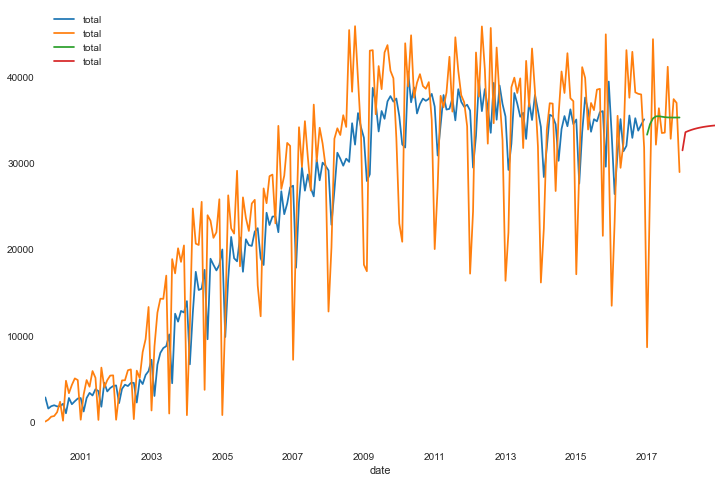

In [50]:
pred2TBATS = robjects.r('(forecast::tbats(r_timeseriesTrain))')
fcasttTBATS = robjects.r('as.data.frame(forecast::forecast(forecast::tbats(r_timeseriesTrain),h='+str(predictFieldPeriod)+'))')
fcastFutureTBATS = robjects.r('as.data.frame(forecast::forecast(forecast::tbats(r_timeseriesAll),h='+str(predictFieldPeriod)+'))')

#display(pred2TBATS[13])

dfRTBATS = pd.DataFrame(pd.Series(d[0:len(pred2TBATS[13])]))
dfTBATS = pd.DataFrame(pd.Series(d[len(pred2TBATS[13]):len(pred2TBATS[13])+predictFieldPeriod]))
dfTBATSFuture = pd.DataFrame(pd.Series(d[len(rdataAll):len(rdataAll)+predictFieldPeriod]))

coluna = fcasttTBATS.columns[0]

dfRTBATS[field] = pd.DataFrame(pd.Series(pred2TBATS[13]))
dfTBATS[field] = fcasttTBATS[coluna].values
dfTBATSFuture[field] = fcastFutureTBATS[coluna].values

dfRTBATS.columns=['date',field]
dfRTBATS.index = pd.to_datetime(dfRTBATS['date'])
dfRTBATS.freq = frequence
dfRTBATS = dfRTBATS[[field]]

dfTBATS.columns=['date',field]
dfTBATS.index = pd.to_datetime(dfTBATS['date'])
dfTBATS.freq = frequence
dfTBATS = dfTBATS[[field]]

dfTBATSFuture.columns=['date',field]
dfTBATSFuture.index = pd.to_datetime(dfTBATSFuture['date'])
dfTBATSFuture.freq = frequence
dfTBATSFuture = dfTBATSFuture[[field]]

dfRTBATS.plot(legend=True,figsize=figsize)
dfChoosed[field].plot(legend=True)
dfTBATS[field].plot(legend=True)
dfTBATSFuture[field].plot(legend=True)

print(len(rdataTest),len(dfTBATS[field].values))
print(adjust('TBATS: ',40), forecast_accuracy(rdataTest,dfTBATS[field].values)['rmse'])

In [51]:
display(df_count_day_typeGRP)

Agravo  Agravo Embargos Infringentes  Agravo Inominado  \
judgmentDate                                                           
2000-01-03         0                             0                 0   
2000-01-04         0                             0                 0   
2000-01-05         0                             0                 0   
2000-01-06         0                             0                 0   
2000-01-07         0                             0                 0   
...              ...                           ...               ...   
2017-12-25         0                             0                 0   
2017-12-26         0                             0                 0   
2017-12-27         0                             0                 0   
2017-12-28         0                             0                 0   
2017-12-29         1                             0                 0   

              Agravo Interno  Agravo Lei  Agravo Regimental  \
judgmentDate                                                  
2000-01-03                 0           0                  0   
2000-01-04                 0           0                  0   
2000-01-05                 0           0                  0   
2000-01-06                 0           0                  0   
2000-01-07                 0           0                  0   
...                      ...         ...                ...   
2017-12-25                 0           0                  0   
2017-12-26                 0           0                  0   
2017-12-27                 0           0                  0   
2017-12-28                 0           0                  0   
2017-12-29                 0           0                  0   

              Agravo de Instrumento  \
judgmentDate                          
2000-01-03                        2   
2000-01-04                        0   
2000-01-05                        0   
2000-01-06                        1   
2000-01-07                        0   
...                             ...   
2017-12-25                        0   
2017-12-26                        0   
2017-12-27                        0   
2017-12-28                        1   
2017-12-29                       29   

              Agravo de Instrumento em Recurso Extraordinario  \
judgmentDate                                                    
2000-01-03                                                  0   
2000-01-04                                                  0   
2000-01-05                                                  0   
2000-01-06                                                  0   
2000-01-07                                                  0   
...                                                       ...   
2017-12-25                                                  0   
2017-12-26                                                  0   
2017-12-27                                                  0   
2017-12-28                                                  0   
2017-12-29                                                  0   

              Agravo de Petição  Agravo em Execução  ...  \
judgmentDate                                         ...   
2000-01-03                    0                   0  ...   
2000-01-04                    0                   0  ...   
2000-01-05                    0                   0  ...   
2000-01-06                    0                   0  ...   
2000-01-07                    0                   0  ...   
...                         ...                 ...  ...   
2017-12-25                    0                   0  ...   
2017-12-26                    0                   0  ...   
2017-12-27                    0                   0  ...   
2017-12-28                    0                   0  ...   
2017-12-29                    0                   0  ...   

              Suspenção de Liminar ou Antecipação de Tutela  \
judgmentDate                                               

# VAR 

In [43]:
#eliminar duplicidade para analise
uniqueTypesComparison = []
for i in dfUniqueTypes:
    for i1 in dfUniqueTypes:
        if i != i1:
            if {i1,i} not in uniqueTypesComparison:
                uniqueTypesComparison.append({i,i1})
            

print(len(dfUniqueTypes),len(uniqueTypesComparison))

119 7021


In [207]:
dfVAR = dfChoosed[VARFields[0:]]
dfVAR['month'] = dfVAR.index.month
dfVAR

Apelação Cível  Agravo de Instrumento  Embargos de Declaração  \
judgmentDate                                                                  
2000-01-01                 0                     10                       0   
2000-02-01               151                     35                       2   
2000-03-01               277                     93                      30   
2000-04-01               343                    145                      19   
2000-05-01               595                    318                      78   
...                      ...                    ...                     ...   
2017-08-01              9180                   7284                    5763   
2017-09-01              6915                   6131                    3648   
2017-10-01              8114                   6538                    4982   
2017-11-01              7559                   6124                    4459   
2017-12-01              6542                   5841                    3958   

              Recurso Cível  Agravo  Apelação Crime  Habeas Corpus  \
judgmentDate                                                         
2000-01-01                0       0               0              0   
2000-02-01                0       4               1              0   
2000-03-01                0      17               5              0   
2000-04-01                0      18               3              2   
2000-05-01                0      11               7              3   
...                     ...     ...             ...            ...   
2017-08-01             4238    1977            2912           1440   
2017-09-01             3040    1700            2465           1423   
2017-10-01             4923    1382            2406           1103   
2017-11-01             4339    1905            2885           1274   
2017-12-01             2525    1527            2519           1149   

              Apelação e Reexame Necessário  Reexame Necessário  \
judgmentDate                                                      
2000-01-01                                0                   0   
2000-02-01                               25                   1   
2000-03-01                              118                  21   
2000-04-01                               89                  14   
2000-05-01                               53                  16   
...                                     ...                 ...   
2017-08-01                              843                 295   
2017-09-01                              741                 229   
2017-10-01                              679                 366   
2017-11-01                              545                 197   
2017-12-01                              511                 185   

              Recurso Crime  month  
judgmentDate                        
2000-01-01                0      1  
2000-02-01                0      2  
2000-03-01                0      3  
2000-04-01                0      4  
2000-05-01                0      5  
...                     ...    ...  
2017-08-01              287      8  
2017-09-01              431      9  
2017-10-01              319     10  
2017-11-01              403     11  
2017-12-01              203     12  

[216 rows x 11 columns]

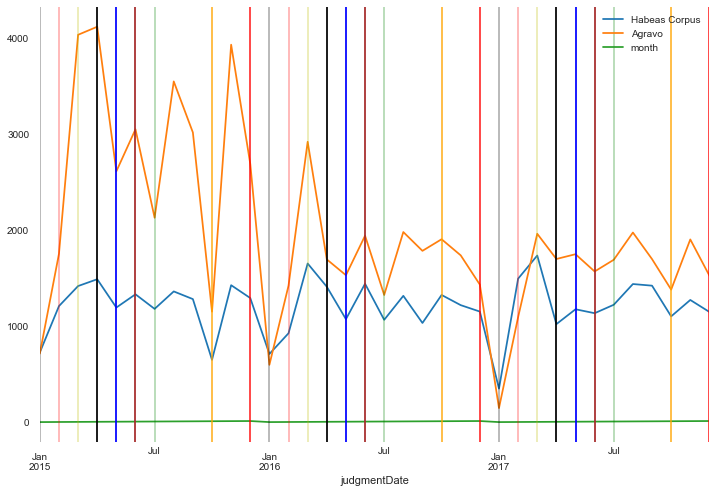

In [208]:
dfAnalise = dfVAR[['Habeas Corpus','Agravo','month']]['2015':]
ax = dfAnalise.plot(figsize=(12,8))
ax.autoscale(axis='x',tight=True)
for x in dfAnalise.query('month==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);
for x in dfAnalise.query('month==2').index: 
    ax.axvline(x=x, color='r', alpha = 0.3);
for x in dfAnalise.query('month==3').index: 
    ax.axvline(x=x, color='y', alpha = 0.3);
for x in dfAnalise.query('month==4').index: 
    ax.axvline(x=x, color='black', alpha = 1);
for x in dfAnalise.query('month==5').index: 
    ax.axvline(x=x, color='blue', alpha = 1);
for x in dfAnalise.query('month==6').index: 
    ax.axvline(x=x, color='brown', alpha = 1);
for x in dfAnalise.query('month==7').index:     
    ax.axvline(x=x, color='g', alpha = 0.3);
for x in dfAnalise.query('month==10').index:     
    ax.axvline(x=x, color='orange', alpha = 0.8);
for x in dfAnalise.query('month==12').index:     
    ax.axvline(x=x, color='red', alpha = 0.8);

216 214
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis 
 Data has no unit root and is stationary
Strong evidence against the null hypothesis 
 Reject the null hypothesis

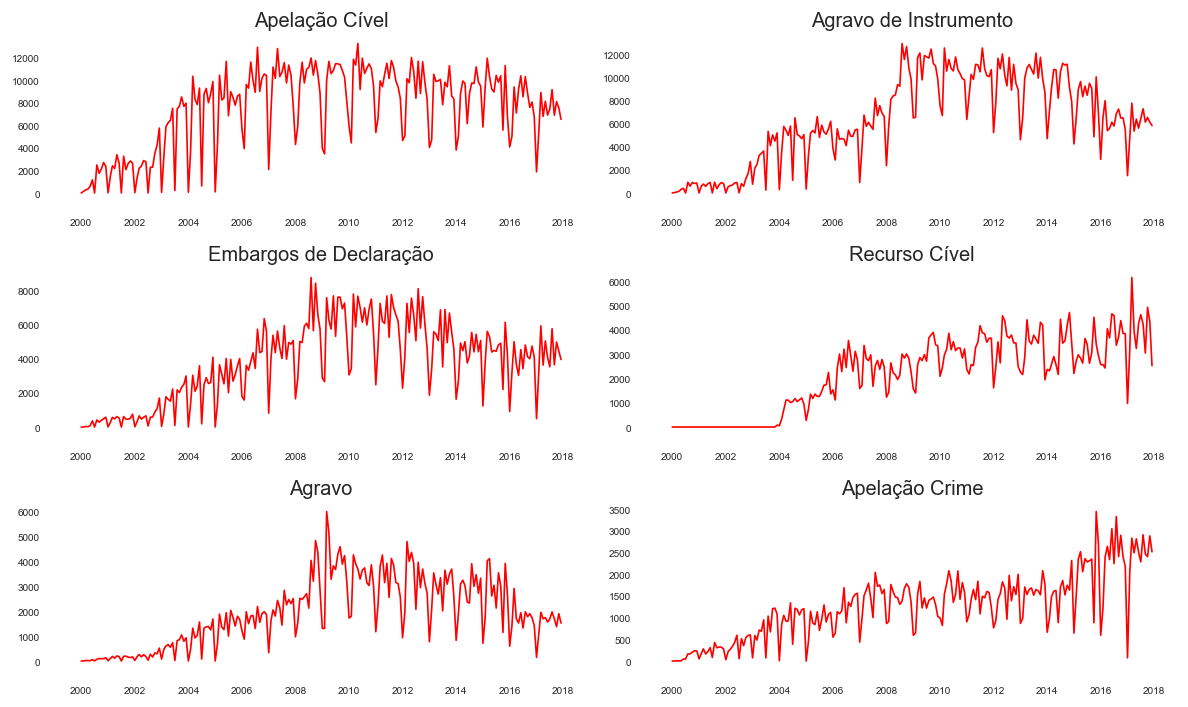

In [209]:
#checar se todos os componentes do VAR são estacionarios 
if 'month' in dfVAR.columns:
    del dfVAR['month']

dfVARDiff = dfVAR.copy()
hasOne = False

for coluna in dfVARDiff.columns:
    while(adf_teste(dfVARDiff[coluna])[0] >= 0.05):
        dfVARDiff = dfVARDiff.diff().dropna()
        break;

print(len(dfVAR),len(dfVARDiff.dropna()))        
    
#testa de novo    
for coluna in dfVARDiff.columns:
    print(adf_teste(dfVARDiff[coluna])[7])
    
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = dfVAR[dfVAR.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(dfVAR.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout();

In [210]:
#fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
#for i, ax in enumerate(axes.flatten()):
#    data = dfVARDiff[dfVARDiff.columns[i]]
#    ax.plot(data, color='red', linewidth=1)
#    # Decorations
#    ax.set_title(dfVARDiff.columns[i])
#    ax.xaxis.set_ticks_position('none')
#    ax.yaxis.set_ticks_position('none')
#    ax.spines["top"].set_alpha(0)
#    ax.tick_params(labelsize=6)   
#    
#plt.tight_layout();

In [211]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            #print(r,c)
            #TooDifferent
            #if TooDifferent(r,c):
            #    print('tirando {r} e {c}')                
            #else:                
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#dfListOfTypes

#dfCorrelationGrangerMatrixStationary = grangers_causation_matrix(dfVARDiff, variables = dfVARDiff.columns) 
dfCorrelationGrangerMatrixNonStationary = grangers_causation_matrix(dfVAR, variables = dfVAR.columns) 

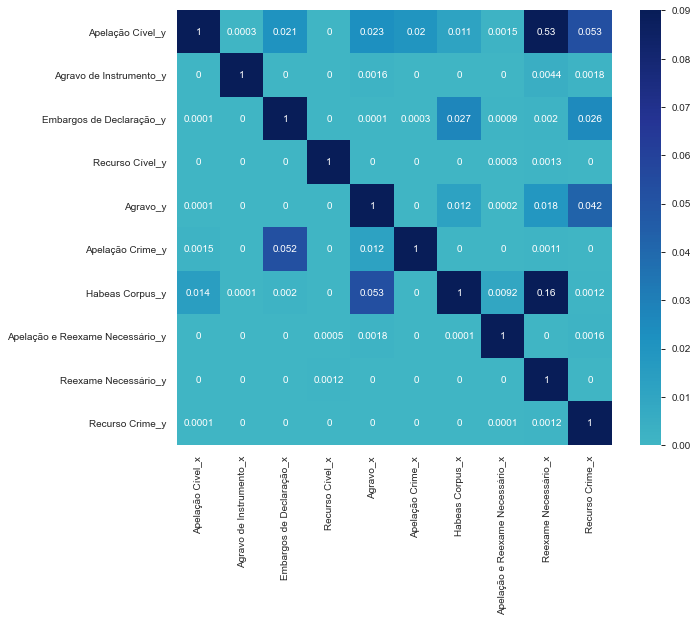

In [212]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(dfCorrelationGrangerMatrixNonStationary, 
            xticklabels=dfCorrelationGrangerMatrixNonStationary.columns.values,
            yticklabels=dfCorrelationGrangerMatrixNonStationary.index.values,center=0,vmax=.09,square=True,cmap="YlGnBu",annot=True) 

In [213]:
import plotly.graph_objects as go

fig = go.Figure()

for i in dfVAR.columns:
    fig.add_trace(go.Scatter(x=dfVAR.reset_index()['judgmentDate'], y=dfVAR[i],
                    mode='lines',
                    name=i))
fig.show()

#fig2 = go.Figure()
#
#for i in dfVARDiff.columns:
#    fig2.add_trace(go.Scatter(x=dfVARDiff.reset_index()['judgmentDate'], y=dfVARDiff[i],
#                    mode='lines',
#                    name=i))
#fig2.show()


In [214]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def adjust(val, length= 6): return str(val).ljust(length)


def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col,35), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(dfVAR)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Apelação Cível                      ::  286.32    > 219.4051  =>   True
Agravo de Instrumento               ::  212.4     > 179.5199  =>   True
Embargos de Declaração              ::  151.91    > 143.6691  =>   True
Recurso Cível                       ::  94.86     > 111.7797  =>   False
Agravo                              ::  63.02     > 83.9383   =>   False
Apelação Crime                      ::  36.58     > 60.0627   =>   False
Habeas Corpus                       ::  22.87     > 40.1749   =>   False
Apelação e Reexame Necessário       ::  9.71      > 24.2761   =>   False
Reexame Necessário                  ::  4.13      > 12.3212   =>   False
Recurso Crime                       ::  0.2       > 4.1296    =>   False


In [215]:
import statsmodels.tsa.stattools as ts
uniqueTypesVARComparison = []
dataVARRes = []
for i in dfVAR.columns:
    for i1 in dfVAR.columns:
        if i != i1:
            if {i1,i} not in uniqueTypesVARComparison:
                coin_result = ts.coint(dfVAR[i], dfVAR[i1]) 
                uniqueTypesVARComparison.append({i1,i})
                dataVARRes.append({'i':i,'i1':i1,'coin_result':coin_result[1]})

dfVARResultTest = pd.DataFrame(dataVARRes)                
display(dfVARResultTest.sort_values(by='coin_result',ascending=True).head(10))
    

i                      i1  coin_result
44             Reexame Necessário           Recurso Crime     0.176926
38                 Apelação Crime           Recurso Crime     0.232223
11          Agravo de Instrumento                  Agravo     0.250139
10          Agravo de Instrumento           Recurso Cível     0.275284
18         Embargos de Declaração                  Agravo     0.286345
41                  Habeas Corpus           Recurso Crime     0.292827
43  Apelação e Reexame Necessário           Recurso Crime     0.309495
29                  Recurso Cível           Recurso Crime     0.399450
42  Apelação e Reexame Necessário      Reexame Necessário     0.415132
9           Agravo de Instrumento  Embargos de Declaração     0.420603

In [216]:
#cointegration_test(dfVARDiff)

In [217]:
nobs = sazonalPeriod
dfVAR_train, dfVAR_test = dfVAR[0:-nobs], dfVAR[-nobs:]
dfVAR_test

Apelação Cível  Agravo de Instrumento  Embargos de Declaração  \
judgmentDate                                                                  
2017-01-01              1879                   1504                     489   
2017-02-01              5425                   4793                    3275   
2017-03-01              8927                   7773                    5931   
2017-04-01              6805                   5351                    3630   
2017-05-01              8146                   6397                    5045   
2017-06-01              6918                   5602                    4077   
2017-07-01              7446                   6416                    3528   
2017-08-01              9180                   7284                    5763   
2017-09-01              6915                   6131                    3648   
2017-10-01              8114                   6538                    4982   
2017-11-01              7559                   6124                    4459   
2017-12-01              6542                   5841                    3958   

              Recurso Cível  Agravo  Apelação Crime  Habeas Corpus  \
judgmentDate                                                         
2017-01-01              968     147              74            350   
2017-02-01             3194    1095            2064           1496   
2017-03-01             6150    1964            2833           1737   
2017-04-01             3920    1701            2493           1022   
2017-05-01             3229    1751            2817           1177   
2017-06-01             4266    1571            2505           1136   
2017-07-01             4621    1693            2287           1224   
2017-08-01             4238    1977            2912           1440   
2017-09-01             3040    1700            2465           1423   
2017-10-01             4923    1382            2406           1103   
2017-11-01             4339    1905            2885           1274   
2017-12-01             2525    1527            2519           1149   

              Apelação e Reexame Necessário  Reexame Necessário  Recurso Crime  
judgmentDate                                                                    
2017-01-01                              131                  93            222  
2017-02-01                              554                 471            140  
2017-03-01                              839                 589            275  
2017-04-01                              658                 344            157  
2017-05-01                              790                 360            405  
2017-06-01                              685                 453            356  
2017-07-01                              669                 292            389  
2017-08-01                              843                 295            287  
2017-09-01                              741                 229            431  
2017-10-01                              679                 366            319  
2017-11-01                              545                 197            403  
2017-12-01                              511                 185            203

In [218]:
dfVARDifference = dfVAR.copy()
#dfVARDifference = dfVARDifference[['Apelação Crime','Recurso Crime']]
tt=0
#while tt < 6:
#    dfVARDifference = dfVARDifference.diff().dropna()
    

for coluna in dfVARDifference.columns:
    while(adf_teste(dfVARDifference[coluna])[0] >= 0.05):
        dfVARDifference = dfVARDifference.diff().dropna()
        tt=tt+1
        break;

print(tt)
        
for coluna in dfVARDifference.columns:
     if adf_teste(dfVARDifference[coluna])[0] >= 0.05:
        print('erro')       

2


In [219]:
model = VAR(dfVARDifference)
for i in [1,2,3,4,5,6,7,8,9]:
    try:
        result = model.fit(i)
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        print('erro, \n')
        continue

model.select_order(9).summary()

Lag Order = 1
AIC :  122.53953721458149
BIC :  124.2754157978117
FPE :  1.654414187100315e+53
HQIC:  123.24106352809581 

Lag Order = 2
AIC :  120.26567155045511
BIC :  123.59059191687551
FPE :  1.712175688914468e+52
HQIC:  121.6095266962767 

Lag Order = 3
AIC :  118.96731850234433
BIC :  123.89184940934707
FPE :  4.7440864603060394e+51
HQIC:  120.9579117036309 

Lag Order = 4
AIC :  118.50339065792457
BIC :  125.03821964646819
FPE :  3.0720074872964385e+51
HQIC:  121.14517984038868 

Lag Order = 5
AIC :  117.32943572339168
BIC :  125.48537097938237
FPE :  9.98081029045012e+50
HQIC:  120.62692824474324 

Lag Order = 6
AIC :  116.9475317694196
BIC :  126.73550402238982
FPE :  7.357207408624843e+50
HQIC:  120.9052851623882 

Lag Order = 7
AIC :  116.37977560270011
BIC :  127.81084006269244
FPE :  4.665895843453309e+50
HQIC:  121.00239833193305 

Lag Order = 8
AIC :  115.91767777708296
BIC :  129.00301611067306
FPE :  3.4419227082162964e+50
HQIC:  121.20983001022185 

Lag Order = 9
AIC :

<class 'statsmodels.iolib.table.SimpleTable'>

In [239]:
model_fitted = model.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Jun, 2020
Time:                     23:16:06
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    129.923
Nobs:                     205.000    HQIC:                   121.138
Log likelihood:          -13803.9    FPE:                2.02601e+50
AIC:                      115.172    Det(Omega_mle):     5.14354e+48
--------------------------------------------------------------------
Results for equation Apelação Cível
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                  -20.667339       143.992686           -0.144           0.886
L1.Apelação Cível                       -1.152577         0.197668         

In [240]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(dfVARDifference.columns, out):
    detail = ""
    if  round(val, 2) > 2:
        detail = "Negative Serial Correlation"
    else:
        detail = "Positive Serial Correlation"
    print((adjust(col)+':').ljust(30, ' '), round(val, 2), ' ' + detail)

Apelação Cível:                2.04  Negative Serial Correlation
Agravo de Instrumento:         2.03  Negative Serial Correlation
Embargos de Declaração:        1.97  Positive Serial Correlation
Recurso Cível:                 2.09  Negative Serial Correlation
Agravo:                        1.92  Positive Serial Correlation
Apelação Crime:                1.87  Positive Serial Correlation
Habeas Corpus:                 1.94  Positive Serial Correlation
Apelação e Reexame Necessário: 2.16  Negative Serial Correlation
Reexame Necessário:            2.04  Negative Serial Correlation
Recurso Crime:                 2.03  Negative Serial Correlation


In [241]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = dfVARDifference.values[-lag_order:]
forecast_input

9


array([[-5624., -5402., -4957., -5186., -1132., -1109.,  -956.,  -466.,
         -363.,  -253.],
       [ 3463.,  3468.,  3716.,  1539.,   313.,   664.,   870.,   313.,
          261.,   366.],
       [-2569., -1841., -2383.,  1728.,  -230.,  -636.,  -196.,  -237.,
           77.,  -297.],
       [ 1756.,  1609.,   419.,  -682.,   302.,    94.,   129.,    89.,
         -254.,    82.],
       [ 1206.,    54.,  2784.,  -738.,   162.,   843.,   128.,   190.,
          164.,  -135.],
       [-3999., -2021., -4350.,  -815.,  -561., -1072.,  -233.,  -276.,
          -69.,   246.],
       [ 3464.,  1560.,  3449.,  3081.,   -41.,   388.,  -303.,    40.,
          203.,  -256.],
       [-1754.,  -821., -1857., -2467.,   841.,   538.,   491.,   -72.,
         -306.,   196.],
       [ -462.,   131.,    22., -1230.,  -901.,  -845.,  -296.,   100.,
          157.,  -284.]])

In [242]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
print(dfVAR.shape,fc.shape)
df_forecast = pd.DataFrame(fc, index=dfVAR.index[-nobs:], columns=dfVARDifference.columns + '_2d')
df_forecast

(216, 10) (12, 10)


Apelação Cível_2d  Agravo de Instrumento_2d  \
judgmentDate                                                
2017-01-01         -3478.738089              -4134.470203   
2017-02-01          7602.576222               7232.696697   
2017-03-01         -2108.489026              -2723.769738   
2017-04-01         -2882.813002              -2422.053446   
2017-05-01          2842.852004               4092.648301   
2017-06-01          -966.655551              -2549.910699   
2017-07-01         -2693.566763               -537.406447   
2017-08-01          6542.923683               4291.055009   
2017-09-01         -5945.302647              -6099.396027   
2017-10-01          2854.768957               4264.002510   
2017-11-01         -4087.745013              -3087.198102   
2017-12-01          6587.330586               3335.802272   

              Embargos de Declaração_2d  Recurso Cível_2d    Agravo_2d  \
judgmentDate                                                             
2017-01-01                 -1672.480234       1699.192663  -576.157123   
2017-02-01                  2144.728641        348.250544   438.642111   
2017-03-01                  1902.662862       -915.235969  2368.026407   
2017-04-01                 -4156.455574       1009.685390 -3368.261084   
2017-05-01                  3384.325046         90.739987  2026.710768   
2017-06-01                 -1392.583322      -2138.160246  -622.086826   
2017-07-01                  -759.623171       2430.279461  -281.516849   
2017-08-01                  2999.575653       -447.614641  1325.864480   
2017-09-01                 -4569.669518      -1247.352729 -1923.410627   
2017-10-01                  3945.866607        932.818087  1116.523227   
2017-11-01                 -2439.270732        -88.189145  -181.796509   
2017-12-01                  1666.678681       -240.264649   308.931292   

              Apelação Crime_2d  Habeas Corpus_2d  \
judgmentDate                                        
2017-01-01          -593.587147        212.806473   
2017-02-01          1181.669429       -301.015969   
2017-03-01           387.203394        637.498322   
2017-04-01          -709.964524       -702.085412   
2017-05-01          -319.503187        353.494113   
2017-06-01           379.192389       -229.088845   
2017-07-01            98.880545        422.261409   
2017-08-01           639.259449       -320.705924   
2017-09-01         -1749.374932       -164.061998   
2017-10-01          1352.775698        343.435348   
2017-11-01          -597.229752       -192.875268   
2017-12-01           705.414278        256.467129   

              Apelação e Reexame Necessário_2d  Reexame Necessário_2d  \
judgmentDate                                                            
2017-01-01                         -832.147616            -252.795576   
2017-02-01                         1350.706083             341.287823   
2017-03-01                         -439.086842              24.111184   
2017-04-01                         -119.857393            -232.276842   
2017-05-01                          -20.302781             181.470875   
2017-06-01                            8.945096            -154.863448   
2017-07-01                         -211.768739              85.024828   
2017-08-01                          723.540334              58.143231   
2017-09-01                        -1037.031886            -256.517282   
2017-10-01                         1087.559232             334.297713   
2017-11-01                        -1118.052049            -234.593093   
2017-12-01                         1006.808479             104.754286   

              Recurso Crime_2d  
judgmentDate                    
2017-01-01          328.614156  
2017-02-01         -217.693972  
2017-03-01           94.175072  
2017-04-01           53.910723  
2017-05-01          -72.814217  
2017-06-01          -70.165600  
2017-07-01          177.331698  
2017-08-01         -165.689031  
2017-09-01           75.98

In [243]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = dfVARDifference.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [244]:
df_results = invert_transformation(dfVAR_train, df_forecast, second_diff=True) 

colunas =[]
for i in df_results.columns:
    if 'forecast' in i:
        colunas.append(i)
print(colunas)

df_results.loc[:, colunas]

['Apelação Cível_forecast', 'Agravo de Instrumento_forecast', 'Embargos de Declaração_forecast', 'Recurso Cível_forecast', 'Agravo_forecast', 'Apelação Crime_forecast', 'Habeas Corpus_forecast', 'Apelação e Reexame Necessário_forecast', 'Reexame Necessário_forecast', 'Recurso Crime_forecast']


Apelação Cível_forecast  Agravo de Instrumento_forecast  \
judgmentDate                                                            
2017-01-01                1991.261911                      352.529797   
2017-02-01                4812.100043                     2444.756290   
2017-03-01                5524.449150                     1813.213047   
2017-04-01                3353.985256                    -1240.383643   
2017-05-01                4026.373365                     -201.332031   
2017-06-01                3732.105923                    -1712.191119   
2017-07-01                 744.271718                    -3760.456653   
2017-08-01                4299.361197                    -1517.667179   
2017-09-01                1909.148029                    -5374.273732   
2017-10-01                2373.703818                    -4966.877774   
2017-11-01               -1249.485407                    -7646.679919   
2017-12-01                1714.655954                    -6990.679791   

              Embargos de Declaração_forecast  Recurso Cível_forecast  \
judgmentDate                                                            
2017-01-01                        1762.519766             5527.192663   
2017-02-01                        1579.768173             7564.635869   
2017-03-01                        3299.679442             8686.843106   
2017-04-01                         863.135137            10818.735734   
2017-05-01                        1810.915879            13041.368349   
2017-06-01                        1366.113297            13125.840719   
2017-07-01                         161.687545            15640.592549   
2017-08-01                        1956.837446            17707.729739   
2017-09-01                        -817.682171            18527.514199   
2017-10-01                         353.664820            20280.116746   
2017-11-01                        -914.258922            21944.530149   
2017-12-01                        -515.503983            23368.678903   

              Agravo_forecast  Apelação Crime_forecast  \
judgmentDate                                             
2017-01-01         552.842877              1371.412853   
2017-02-01         110.327865              1739.495136   
2017-03-01        2035.839261              2494.780813   
2017-04-01         593.089572              2540.101966   
2017-05-01        1177.050651              2265.919933   
2017-06-01        1138.924905              2370.930288   
2017-07-01         819.282310              2574.821188   
2017-08-01        1825.504195              3417.971537   
2017-09-01         908.315452              2511.746954   
2017-10-01        1107.649936              2958.298068   
2017-11-01        1125.187912              2807.619430   
2017-12-01        1451.657179              3362.355071   

              Habeas Corpus_forecast  Apelação e Reexame Necessário_forecast  \
judgmentDate                                                                   
2017-01-01               1298.806473                              383.852384   
2017-02-01               1143.596977                             1153.410850   
2017-03-01               1625.885802                             1483.882474   
2017-04-01               1406.089215                             1694.496706   
2017-05-01               1539.786741                             1884.808156   
2017-06-01               1444.395421                             2084.064702   
2017-07-01               1771.265511                             2071.552510   
2017-08-01               1777.429676                             2782.580651   
2017-09-01               1619.531843                             2456.576907   
2017-10-01               1805.069358                             3218.132395   
2017-11-01               1797.731605                             2861.635833   
2017-12-01               2046.860981                             3511.947751   

              Reexame Necessário_f

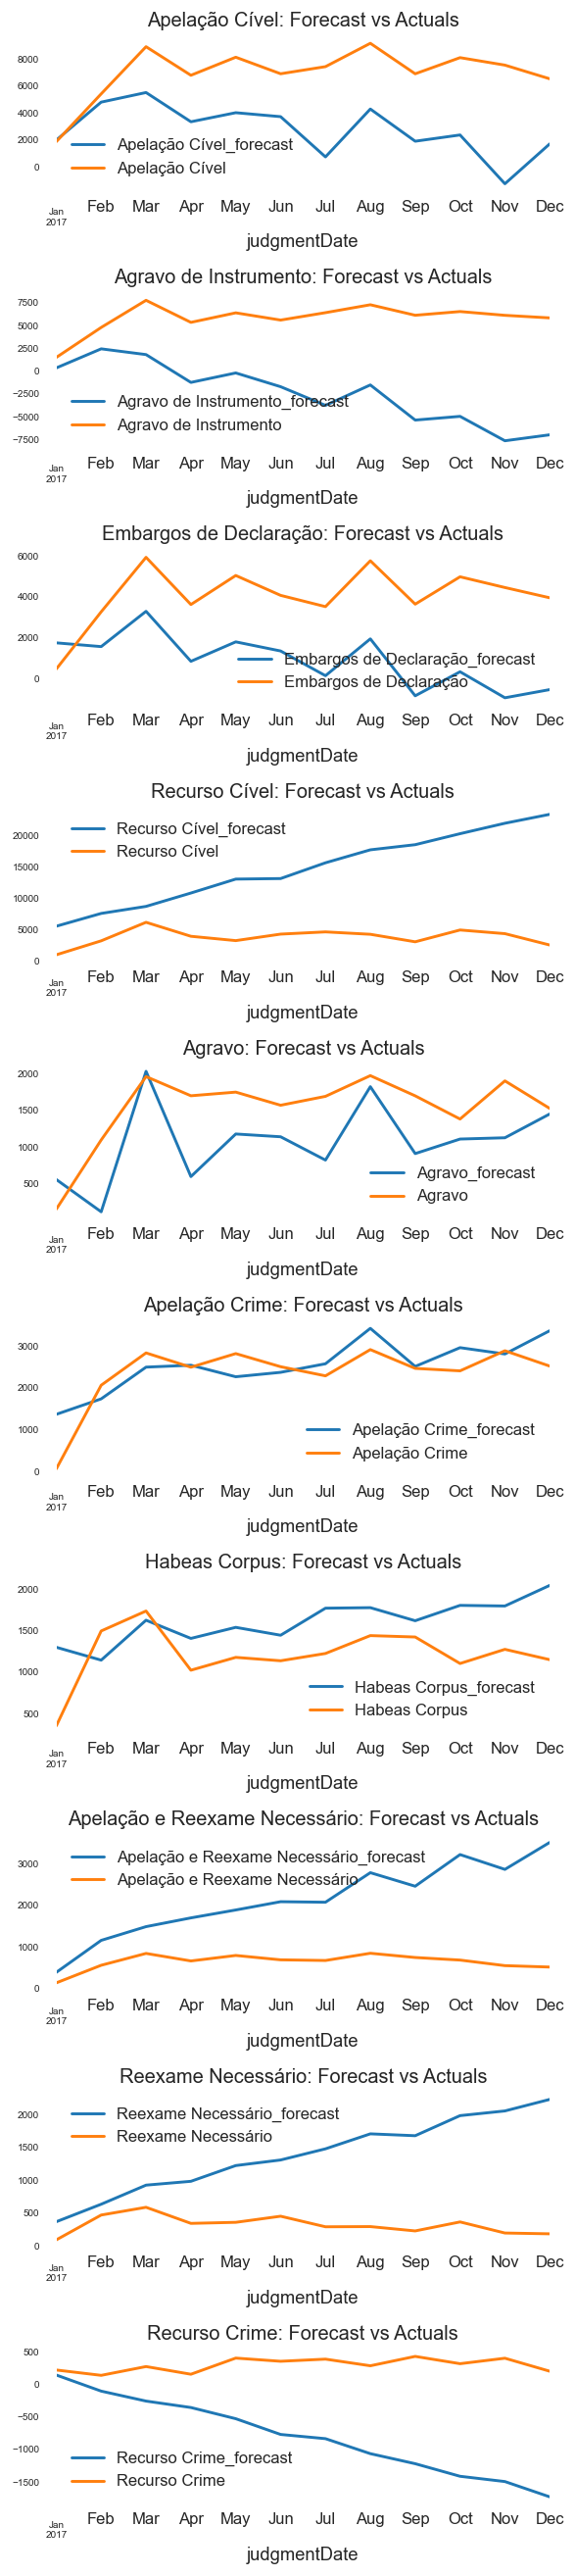

In [245]:
fig, axes = plt.subplots(10, ncols=1, dpi=120,figsize=(5,22))
for i, (col,ax) in enumerate(zip(dfVARDifference.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    dfVAR_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    #ax.xaxis.set_ticks_position('none')
    #ax.yaxis.set_ticks_position('none')
    #ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [246]:
#fig, axes = plt.subplots(2, ncols=2, dpi=300, figsize=(8,4))
#for i, (col,ax) in enumerate(zip(dfVARDifference[['Apelação Cível','Agravo de Instrumento','Embargos de Declaração']].columns, axes.flatten())):
#    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
#    dfVAR_test[col][-nobs:].plot(legend=True, ax=ax);
#    ax.set_title(col + ": Forecast vs Actuals")
#    #ax.xaxis.set_ticks_position('none')
#    #ax.yaxis.set_ticks_position('none')
#    #ax.spines["top"].set_alpha(0)
#    ax.tick_params(labelsize=4)
#
#plt.tight_layout();

In [247]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    media = np.mean(actual)
    return({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax,'media':media})

for i in colunas:
    print(i)
    itemI = i.replace('_forecast','')
    print(f'Forecast Accuracy of: {itemI}')
    accuracy_prod = forecast_accuracy(df_results[i].values, dfVAR_test[itemI])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))
    print('\n')

Apelação Cível_forecast
Forecast Accuracy of: Apelação Cível
mape   :  0.5661
me     :  -4218.6724
mae    :  4237.3827
mpe    :  -0.5562
rmse   :  4818.6475
corr   :  0.1899
minmax :  0.5658
media  :  6988.0


Agravo de Instrumento_forecast
Forecast Accuracy of: Agravo de Instrumento
mape   :  1.3723
me     :  -8212.8369
mae    :  8212.8369
mpe    :  -1.3723
rmse   :  9050.2656
corr   :  -0.2084
minmax :  1.3723
media  :  5812.8333


Embargos de Declaração_forecast
Forecast Accuracy of: Embargos de Declaração
mape   :  0.9781
me     :  -3156.5103
mae    :  3368.7636
mpe    :  -0.544
rmse   :  3570.1324
corr   :  0.1789
minmax :  0.8213
media  :  4065.4167


Recurso Cível_forecast
Forecast Accuracy of: Recurso Cível
mape   :  3.288
me     :  10901.7316
mae    :  10901.7316
mpe    :  3.288
rmse   :  12219.1073
corr   :  0.1681
minmax :  0.7094
media  :  3784.4167


Agravo_forecast
Forecast Accuracy of: Agravo
mape   :  0.5555
me     :  -463.944
mae    :  543.5577
mpe    :  -0.0893
rmse  

In [66]:
dfChoosed[[field]]

total
judgmentDate       
2000-01-01       10
2000-02-01      222
2000-03-01      573
2000-04-01      647
2000-05-01     1096
...             ...
2017-08-01    41151
2017-09-01    32798
2017-10-01    37399
2017-11-01    36963
2017-12-01    28936

[216 rows x 1 columns]

# FACEBOOK PROPHET

In [155]:
from fbprophet import Prophet

dfProphet = dfChoosed[[field]].copy()

dfProphetTrain = dfProphet[:'2016']
dfProphetTrain = dfProphetTrain.reset_index()
dfProphetTrain.columns = ['ds','y']

dfProphetTest = dfProphet['2017':]
dfProphetTest = dfProphetTest.reset_index()
dfProphetTest.columns = ['ds','y']


dfProphet = dfProphet.reset_index()
dfProphet.columns = ['ds','y']

dfProphetTest.tail(20)

ds      y
0  2017-01-01   8625
1  2017-02-01  27182
2  2017-03-01  44352
3  2017-04-01  32122
4  2017-05-01  36348
5  2017-06-01  33469
6  2017-07-01  33513
7  2017-08-01  41151
8  2017-09-01  32798
9  2017-10-01  37399
10 2017-11-01  36963
11 2017-12-01  28936

# ANALISE PARA INDICAÇOES DE SAZONALIDADE 

In [156]:
#dfAnalise = dfChoosed.copy()
#dfAnalise['month'] = dfAnalise.index.month
#dfAnalise = dfAnalise[[field,'month']]['2012':]
#ax = dfAnalise.plot(figsize=(20,12))
#ax.autoscale(axis='x',tight=True)
#for x in dfAnalise.query('month==1').index: 
#    ax.axvline(x=x, color='k', alpha = 0.3);
#for x in dfAnalise.query('month==2').index: 
#    ax.axvline(x=x, color='r', alpha = 0.3);
#for x in dfAnalise.query('month==3').index: 
#    ax.axvline(x=x, color='y', alpha = 0.3);
#for x in dfAnalise.query('month==4').index: 
#    ax.axvline(x=x, color='black', alpha = 1);
#for x in dfAnalise.query('month==5').index: 
#    ax.axvline(x=x, color='blue', alpha = 1);
#for x in dfAnalise.query('month==6').index: 
#    ax.axvline(x=x, color='brown', alpha = 1);
#for x in dfAnalise.query('month==7').index:     
#    ax.axvline(x=x, color='g', alpha = 0.3);
#for x in dfAnalise.query('month==10').index:     
#    ax.axvline(x=x, color='orange', alpha = 0.8);
#for x in dfAnalise.query('month==12').index:     
#    ax.axvline(x=x, color='red', alpha = 0.8);

In [157]:
#dias com sazonalidade baixa .... 
#dfZERADO = df_count_day_type.resample('D').sum()
#dfZeradoDiaMes = dfZERADO[dfZERADO['count']<=10]
#dfZeradoDiaMes['mes'] = dfZeradoDiaMes.index.month
#dfZeradoDiaMes['dia'] = dfZeradoDiaMes.index.day
#dfDayLowResult = dfZeradoDiaMes.groupby(['mes','dia']).count().sort_values(by='Feriado',ascending=False)
#dfDayLowResult = dfDayLowResult[dfDayLowResult['Feriado']>=9].reset_index()
#dfDayLowResult

In [158]:
import datetime

preNatalPreAnoNovo = []

for year in range(2000,2026):
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-12-24',format='%Y-%m-%d'))
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-12-31',format='%Y-%m-%d'))
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-09-20',format='%Y-%m-%d'))
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-09-07',format='%Y-%m-%d'))
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-11-15',format='%Y-%m-%d'))    
    #preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-02-02',format='%Y-%m-%d')) (apenas porto alegre)
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-05-01',format='%Y-%m-%d'))
    preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-11-02',format='%Y-%m-%d'))
    #preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-04-21',format='%Y-%m-%d'))
    #preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-10-12',format='%Y-%m-%d'))
    #preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-10-12',format='%Y-%m-%d'))
    for dia in range(20,32):
        preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-12-{dia}',format='%Y-%m-%d'))
    for dia in range(1,7):
        preNatalPreAnoNovo.append(pd.to_datetime(f'{year}-01-{dia}',format='%Y-%m-%d'))
        
preNatalAnoNovoOutrosFeriados = pd.Series(preNatalPreAnoNovo).drop_duplicates()    
display(len(preNatalAnoNovoOutrosFeriados))

598

# PREPARACAO DOS DADOS 

In [159]:
dfFeriados = df_count_day_type.reset_index()
dfFeriados = dfFeriados[['judgmentDate','Feriado']]
feriados = pd.Series(dfFeriados[dfFeriados['Feriado']==True]['judgmentDate'])
np.array(feriados)

feriadosGauchos = pd.DataFrame({
  'holiday': 'feriadosGauchos',
  'ds': pd.to_datetime(feriados),
  'lower_window': 0,
  'upper_window': 1,
})

np.array

feriadosAntecipados = pd.DataFrame({
  'holiday': 'feriadosAntecipados',
   'ds': preNatalAnoNovoOutrosFeriados,
  'lower_window': 0,
  'upper_window': 1,
})

feriadosGerais = pd.concat((feriadosGauchos, feriadosAntecipados))



def is_not_year_season(ds):
    date = pd.to_datetime(ds)
    return (date.month == 6 or date.month ==1 or date.month ==2 or date.month ==5)
    #return (date.month == 4 or date.month ==1 or date.month ==10 or date.month ==5)

#dfProphet['on_season'] = ~dfProphet['ds'].apply(is_not_year_season)
#dfProphet['off_season'] = dfProphet['ds'].apply(is_not_year_season)


#dfProphetTrain['on_season'] = ~dfProphetTrain['ds'].apply(is_not_year_season)
#dfProphetTrain['off_season'] = dfProphetTrain['ds'].apply(is_not_year_season)


frequence = ''

if dfChoosed[field]['2016'].count() == 12:
    frequence = 'MS'

if dfChoosed[field]['2016'].count() == 4:
    frequence = 'QS'
    
if dfChoosed[field]['2016'].count() == 1:
    frequence = 'A'
    
print(frequence)    

MS


In [160]:
dfProphetTrain

ds      y
0   2000-01-01     10
1   2000-02-01    222
2   2000-03-01    573
3   2000-04-01    647
4   2000-05-01   1096
..         ...    ...
199 2016-08-01  42889
200 2016-09-01  38185
201 2016-10-01  38016
202 2016-11-01  37940
203 2016-12-01  31787

[204 rows x 2 columns]

In [164]:
#mProphet = Prophet(yearly_seasonality=sazonalPeriod,changepoint_prior_scale=180,holidays=feriadosGerais)
mProphet = Prophet(seasonality_mode='multiplicative')
#mProphet.add_seasonality(name='monthly', period=12, fourier_order=1)
#mProphet.add_country_holidays(country_name='BR')
mProphet.fit(dfProphetTrain)
#display('Feriados BR',mProphet.train_holiday_names)
#display(mProphet.holidays)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [165]:
display(dfProphetTrain.tail(3))
display(dfProphetTest.tail(3))

ds      y
201 2016-10-01  38016
202 2016-11-01  37940
203 2016-12-01  31787

ds      y
9  2017-10-01  37399
10 2017-11-01  36963
11 2017-12-01  28936

In [166]:
futureProphet = mProphet.make_future_dataframe(periods=predictFieldPeriod,freq=frequence)
#futureProphet = mProphet.make_future_dataframe(periods=predictFieldPeriod)
futureProphet.tail()
forecastProphet = mProphet.predict(futureProphet)
forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
211 2017-08-01  40743.128978  36252.444074  44953.195729
212 2017-09-01  36180.974797  31814.758437  40508.882712
213 2017-10-01  37344.161584  32783.515260  41584.878453
214 2017-11-01  36961.756022  32556.745818  41513.157947
215 2017-12-01  32771.778723  28362.846869  37212.651466

In [167]:
display(dfProphetTest.tail(3))
display(forecastProphet.tail(3))

ds      y
9  2017-10-01  37399
10 2017-11-01  36963
11 2017-12-01  28936

ds         trend    yhat_lower    yhat_upper   trend_lower  \
213 2017-10-01  33496.440676  32783.515260  41584.878453  33373.249014   
214 2017-11-01  33461.920531  32556.745818  41513.157947  33319.070440   
215 2017-12-01  33428.513938  28362.846869  37212.651466  33260.928366   

      trend_upper  multiplicative_terms  multiplicative_terms_lower  \
213  33639.690894              0.114870                    0.114870   
214  33627.705383              0.104592                    0.104592   
215  33621.938021             -0.019646                   -0.019646   

     multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
213                    0.114870  0.114870      0.114870      0.114870   
214                    0.104592  0.104592      0.104592      0.104592   
215                   -0.019646 -0.019646     -0.019646     -0.019646   

     additive_terms  additive_terms_lower  additive_terms_upper          yhat  
213             0.0                   0.0                   0.0  37344.161584  
214             0.0                   0.0                   0.0  36961.756022  
215             0.0                   0.0                   0.0  32771.778723

In [168]:
#fig1 = mProphet.plot(forecastProphet[:])
#fig2 = mProphet.plot_components(forecastProphet[:])

In [169]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()
figProphet = plot_plotly(mProphet, forecastProphet)  # This returns a plotly Figure
#py.iplot(figProphet)
dfFaceForecast = forecastProphet

In [170]:
display(dfChoosed[[field]].tail())
display(forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

total
judgmentDate       
2017-08-01    41151
2017-09-01    32798
2017-10-01    37399
2017-11-01    36963
2017-12-01    28936

ds          yhat    yhat_lower    yhat_upper
204 2017-01-01  16042.201910  11249.709168  20551.272069
205 2017-02-01  21517.755759  17052.273832  26005.824807
206 2017-03-01  38011.853622  33617.044336  42444.863097
207 2017-04-01  35840.901058  31458.878275  40419.356930
208 2017-05-01  36540.433667  32143.031391  40932.476482
209 2017-06-01  37393.408811  32843.272878  42050.528208
210 2017-07-01  31870.226953  27731.676620  36351.938846
211 2017-08-01  40743.128978  36252.444074  44953.195729
212 2017-09-01  36180.974797  31814.758437  40508.882712
213 2017-10-01  37344.161584  32783.515260  41584.878453
214 2017-11-01  36961.756022  32556.745818  41513.157947
215 2017-12-01  32771.778723  28362.846869  37212.651466

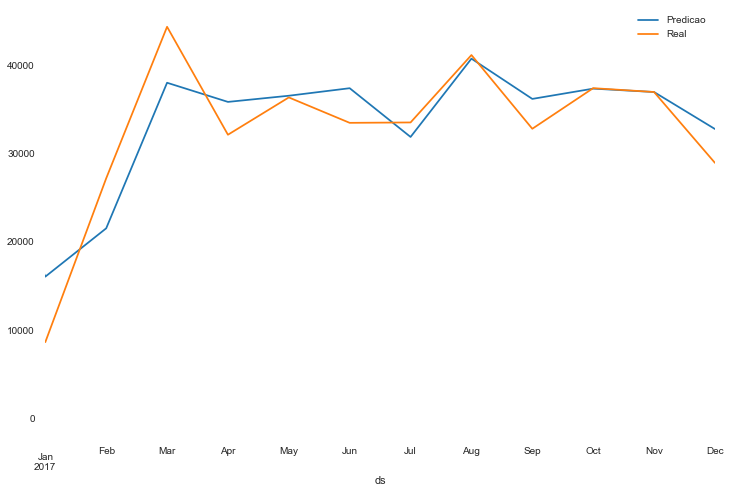

In [171]:
ax = forecastProphet.plot(x='ds',y='yhat',label='Predicao',legend=True,figsize=(12,8))
dfProphetTest.plot(x='ds',y='y',label='Real',legend=True,ax=ax,xlim=('2017-01-01','2017-12-01'))

In [172]:
predictions = forecastProphet.iloc[-12:]['yhat']
pd.DataFrame(predictions)

yhat
204  16042.201910
205  21517.755759
206  38011.853622
207  35840.901058
208  36540.433667
209  37393.408811
210  31870.226953
211  40743.128978
212  36180.974797
213  37344.161584
214  36961.756022
215  32771.778723

In [173]:
predictionFacebook = pd.DataFrame(predictions)
#display(predictionFacebook)
#predictionFacebook.index = predictionFacebook['ds']
#if 'ds' in predictionFacebook.columns:
#    del predictionFacebook['ds']
display(predictionFacebook)

yhat
204  16042.201910
205  21517.755759
206  38011.853622
207  35840.901058
208  36540.433667
209  37393.408811
210  31870.226953
211  40743.128978
212  36180.974797
213  37344.161584
214  36961.756022
215  32771.778723

In [174]:
print(rmse(predictions,dfProphetTest['y']),dfProphetTest['y'].mean())
#display(dfProphetTest['y'])
#display(dfProphet['y'])
#display(forecastProphet['yhat'])

3932.6627021144695 32738.166666666668


FACEBOOK PROPHET:                        3932.6627021144695
FACEBOOK PROPHET:                        3516.0990659315885


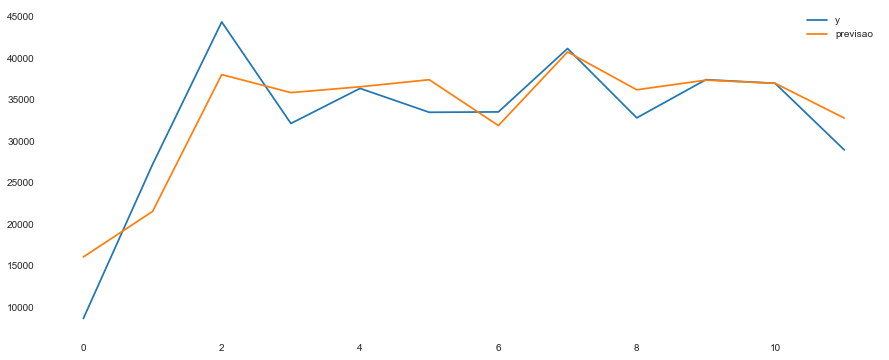

In [175]:
dfFaceForecast.index = pd.to_datetime(dfFaceForecast['ds'])
dfProphetTrain.index = pd.to_datetime(dfProphetTrain['ds'])
dfProphetTest['y'].plot(figsize=(15,6),legend=True)
pd.Series(forecastProphet['yhat'][-12:].values).rename('previsao').plot(legend=True)


print(adjust('FACEBOOK PROPHET: ',40), forecast_accuracy(dfProphetTest['y'].values,predictions)['rmse'])
print(adjust('FACEBOOK PROPHET: ',40), forecast_accuracy(dfProphet['y'].values,forecastProphet['yhat'].values)['rmse'])
#print(adjust('FACEBOOK PROPHET: ',40), forecast_accuracy(dfProphet['y'][-24:].values,forecastProphet['yhat'][-36:-12].values)['rmse'])

In [113]:
predictionFacebook1 = predictions.copy()
predictionFacebook1 = pd.DataFrame(predictionFacebook1)
d = pd.date_range(start='2017-01-01', end='2017-12-01', freq='MS')   
predictionFacebook1.index = d
display(predictionFacebook1)


predictionFacebook0 = predictionFacebook1.asfreq("MS")
print(predictionFacebook0.index)
print(predictionsARMANodiff.index)
display(predictionFacebook0)
display(pd.DataFrame(predictionsARMANodiff))

yhat
2017-01-01  20772.345718
2017-02-01  24798.887146
2017-03-01  37727.444739
2017-04-01  35782.096273
2017-05-01  36385.737805
2017-06-01  37414.127865
2017-07-01  31312.188259
2017-08-01  39801.497119
2017-09-01  36015.410134
2017-10-01  37174.733559
2017-11-01  36901.721866
2017-12-01  34196.321371

DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')
DatetimeIndex(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', freq='MS')


yhat
2017-01-01  20772.345718
2017-02-01  24798.887146
2017-03-01  37727.444739
2017-04-01  35782.096273
2017-05-01  36385.737805
2017-06-01  37414.127865
2017-07-01  31312.188259
2017-08-01  39801.497119
2017-09-01  36015.410134
2017-10-01  37174.733559
2017-11-01  36901.721866
2017-12-01  34196.321371

SARIMAX((3, 1, 3),(2, 0, 0, 12)) Predictions
2017-01-01                                  18761.553189
2017-02-01                                  25808.897206
2017-03-01                                  36495.342916
2017-04-01                                  34049.790498
2017-05-01                                  33629.643124
2017-06-01                                  39216.142511
2017-07-01                                  36156.596089
2017-08-01                                  40232.481073
2017-09-01                                  37879.717382
2017-10-01                                  33217.384852
2017-11-01                                  38655.356917
2017-12-01                                  32232.589853

In [114]:
#FACEBOOK PROPHET:                        3410.6127764365747
#FACEBOOK PROPHET:                        3407.1908733806695
#FACEBOOK PROPHET:                        3343.0582487657043 melhorado parametro do fourier_order
#FACEBOOK PROPHET:                        3341.602782603631  adicionado recesso judiciario 


In [115]:
#colocando as datas de 24/12 e 31/12 como feriados o modelo ficou ainda melhor, mesmo se tratando de uma analise mensal
#melhorou em 0050
#acerto nao melhorou mt mais colocando todas as datas possiveis

#  PROPHET + ARIMA

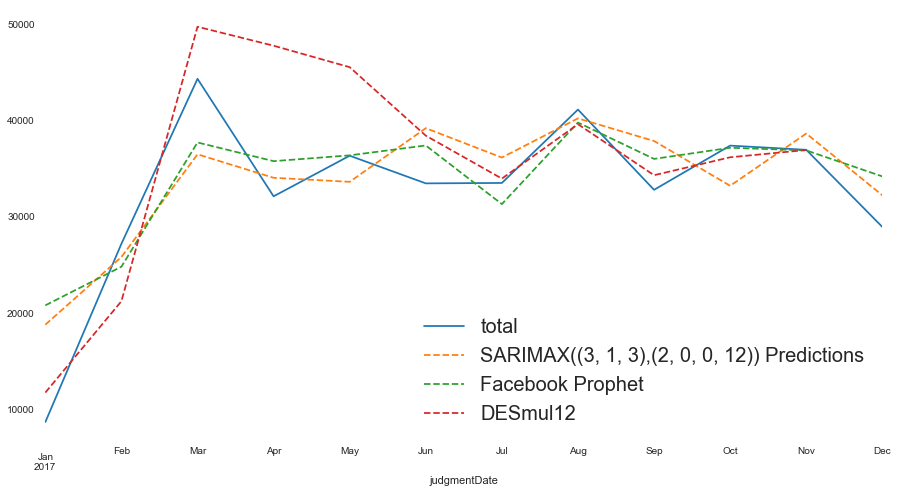

In [116]:
dfChoosed[field]['2017'].plot(legend=True)
predictionsARMANodiff.plot(style='--',legend=True)
predictionFacebook0['yhat'].rename('Facebook Prophet').plot(style='--',legend=True)
dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)]['2017'].plot(style='--',legend=True).legend(fontsize=20)




In [151]:
#mProphet = Prophet(yearly_seasonality=sazonalPeriod,changepoint_prior_scale=180,holidays=feriadosGerais)
for param in range(1,2):
    #mProphet = Prophet()
    mProphet = Prophet(daily_seasonality=False, weekly_seasonality=7,yearly_seasonality=True,changepoint_prior_scale=0.5,seasonality_mode='multiplicative')
    print(param)
    mProphet.add_seasonality(name='monthly', period=30, fourier_order=10)    
    #mProphet.add_seasonality(name='weekly', period=7, fourier_order=20)
    #mProphet.add_seasonality(name='yearly', period=365.25, fourier_order=20)

    mProphet.add_country_holidays(country_name='BR')    
    mProphet.fit(dfProphetTrain)
    futureProphet = mProphet.make_future_dataframe(periods=predictFieldPeriod,freq=frequence)
    forecastProphet = mProphet.predict(futureProphet)
    forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    dfFaceForecast = forecastProphet
    #ax = forecastProphet.plot(x='ds',y='yhat',label='Predicao',legend=True,figsize=(12,8))
    #dfProphetTest.plot(x='ds',y='y',label='Real',legend=True,ax=ax,xlim=('2017-01-01','2017-12-01'))
    predictions = forecastProphet.iloc[-12:]['yhat']
    print(rmse(predictions,dfProphetTest['y']),dfProphetTest['y'].mean())
    dfFaceForecast.index = pd.to_datetime(dfFaceForecast['ds'])
    dfProphetTrain.index = pd.to_datetime(dfProphetTrain['ds'])
    
    print(adjust('FACEBOOK PROPHET: ',40), forecast_accuracy(dfProphetTest['y'].values,predictions)['rmse'])
    print(adjust('FACEBOOK PROPHET: ',40), forecast_accuracy(dfProphet['y'].values,forecastProphet['yhat'].values)['rmse'])

1
3722.139398909613 32738.166666666668
FACEBOOK PROPHET:                        3722.139398909613
FACEBOOK PROPHET:                        3025.2367418936756


FACEBOOK PROPHET:                        3722.139398909613
FACEBOOK PROPHET:                        3025.2367418936756


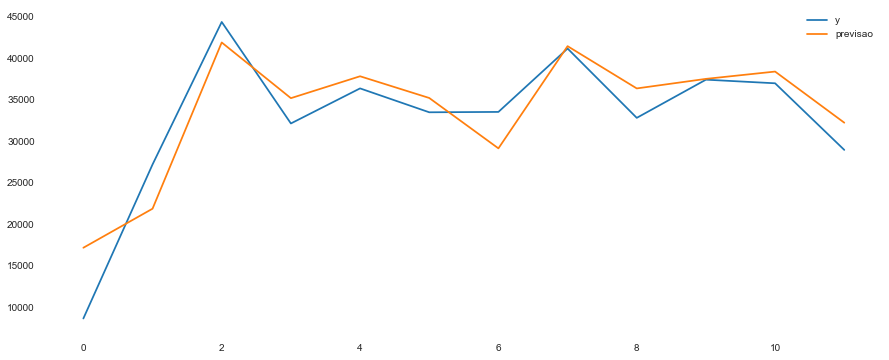

In [152]:
dfFaceForecast.index = pd.to_datetime(dfFaceForecast['ds'])
dfProphetTrain.index = pd.to_datetime(dfProphetTrain['ds'])
dfProphetTest['y'].plot(figsize=(15,6),legend=True)
pd.Series(forecastProphet['yhat'][-12:].values).rename('previsao').plot(legend=True)


print(adjust('FACEBOOK PROPHET: ',40), forecast_accuracy(dfProphetTest['y'].values,predictions)['rmse'])
print(adjust('FACEBOOK PROPHET: ',40), forecast_accuracy(dfProphet['y'].values,forecastProphet['yhat'].values)['rmse'])
#print(adjust('FACEBOOK PROPHET: ',40), forecast_accuracy(dfProphet['y'][-24:].values,forecastProphet['yhat'][-36:-12].values)['rmse'])

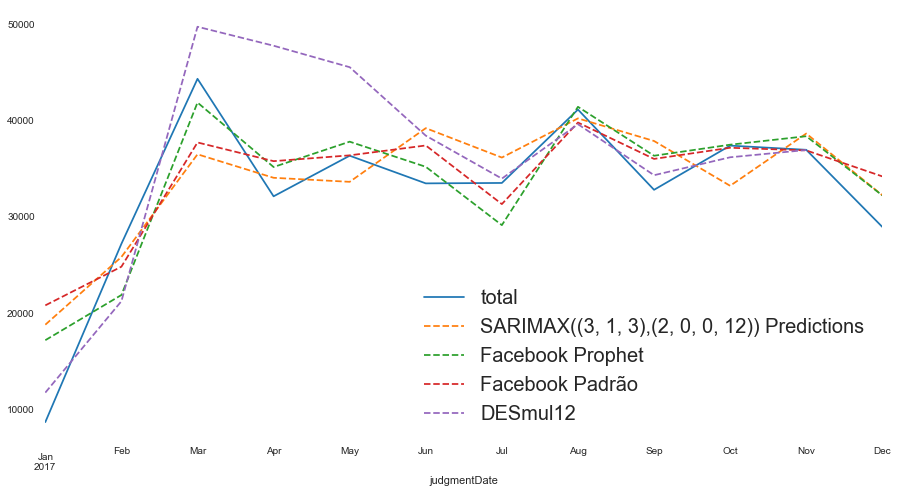

In [153]:
predictionFacebook1 = predictions.copy()
predictionFacebook1 = pd.DataFrame(predictionFacebook1)
d = pd.date_range(start='2017-01-01', end='2017-12-01', freq='MS')   
predictionFacebook1.index = d
#display(predictionFacebook1)


predictionFacebook1 = predictionFacebook1.asfreq("MS")
dfChoosed[field]['2017'].plot(legend=True)
predictionsARMANodiff.plot(style='--',legend=True)
predictionFacebook1['yhat'].rename('Facebook Prophet').plot(style='--',legend=True)
predictionFacebook0['yhat'].rename('Facebook Padrão').plot(style='--',legend=True)
dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)]['2017'].plot(style='--',legend=True).legend(fontsize=20)

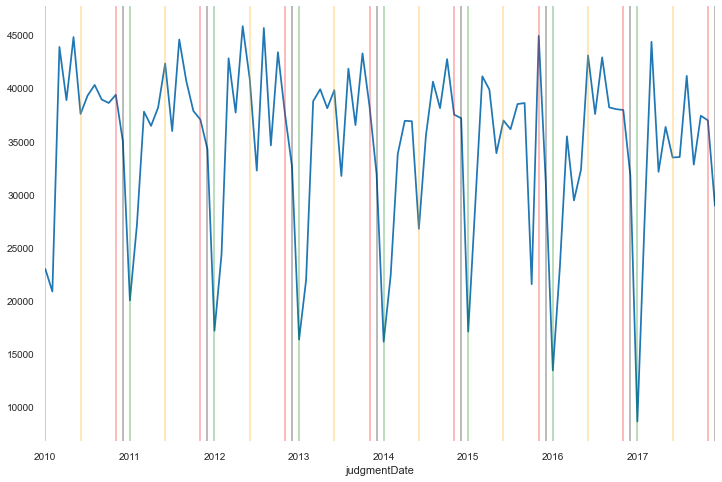

In [154]:
dfAnalise = dfChoosed[field]['2010':].copy()
dfAnalise = dfAnalise.reset_index()
dfAnalise.index = dfAnalise.judgmentDate
del dfAnalise['judgmentDate']
#display(dfAnalise[dfAnalise.index.month==12].index)

#display(pd.DataFrame(dfAnalise))
ax = dfAnalise['total'].plot(figsize=(12,8))
ax.autoscale(axis='x',tight=True)
for x in dfAnalise[dfAnalise.index.month==12].index: 
    ax.axvline(x=x, color='k', alpha = 0.3);
for x in dfAnalise[dfAnalise.index.month==11].index: 
    ax.axvline(x=x, color='r', alpha = 0.3);
for x in dfAnalise[dfAnalise.index.month==1].index: 
    ax.axvline(x=x, color='g', alpha = 0.3);
for x in dfAnalise[dfAnalise.index.month==6].index: 
    ax.axvline(x=x, color='orange', alpha = 0.3);
    
#for x in dfAnalise.query('month==3').index: 
#    ax.axvline(x=x, color='y', alpha = 0.3);
#for x in dfAnalise.query('month==4').index: 
#    ax.axvline(x=x, color='black', alpha = 1);
#for x in dfAnalise.query('month==5').index: 
#    ax.axvline(x=x, color='blue', alpha = 1);
#for x in dfAnalise.query('month==6').index: 
#    ax.axvline(x=x, color='brown', alpha = 1);
#for x in dfAnalise.query('month==7').index:     
#    ax.axvline(x=x, color='g', alpha = 0.3);
#for x in dfAnalise.query('month==10').index:     
#    ax.axvline(x=x, color='orange', alpha = 0.8);
#for x in dfAnalise.query('month==12').index:     
#    ax.axvline(x=x, color='red', alpha = 0.8);

# LSTM

Epoch 1/100
 - 1s - loss: 0.0477
Epoch 2/100
 - 0s - loss: 0.0227
Epoch 3/100
 - 0s - loss: 0.0175
Epoch 4/100
 - 0s - loss: 0.0159
Epoch 5/100
 - 0s - loss: 0.0130
Epoch 6/100
 - 0s - loss: 0.0118
Epoch 7/100
 - 0s - loss: 0.0102
Epoch 8/100
 - 0s - loss: 0.0097
Epoch 9/100
 - 0s - loss: 0.0108
Epoch 10/100
 - 0s - loss: 0.0096
Epoch 11/100
 - 0s - loss: 0.0089
Epoch 12/100
 - 0s - loss: 0.0099
Epoch 13/100
 - 0s - loss: 0.0090
Epoch 14/100
 - 0s - loss: 0.0103
Epoch 15/100
 - 0s - loss: 0.0105
Epoch 16/100
 - 0s - loss: 0.0083
Epoch 17/100
 - 0s - loss: 0.0088
Epoch 18/100
 - 0s - loss: 0.0093
Epoch 19/100
 - 0s - loss: 0.0092
Epoch 20/100
 - 0s - loss: 0.0085
Epoch 21/100
 - 0s - loss: 0.0086
Epoch 22/100
 - 0s - loss: 0.0085
Epoch 23/100
 - 0s - loss: 0.0083
Epoch 24/100
 - 0s - loss: 0.0083
Epoch 25/100
 - 0s - loss: 0.0090
Epoch 26/100
 - 0s - loss: 0.0093
Epoch 27/100
 - 0s - loss: 0.0082
Epoch 28/100
 - 0s - loss: 0.0091
Epoch 29/100
 - 0s - loss: 0.0089
Epoch 30/100
 - 0s - lo

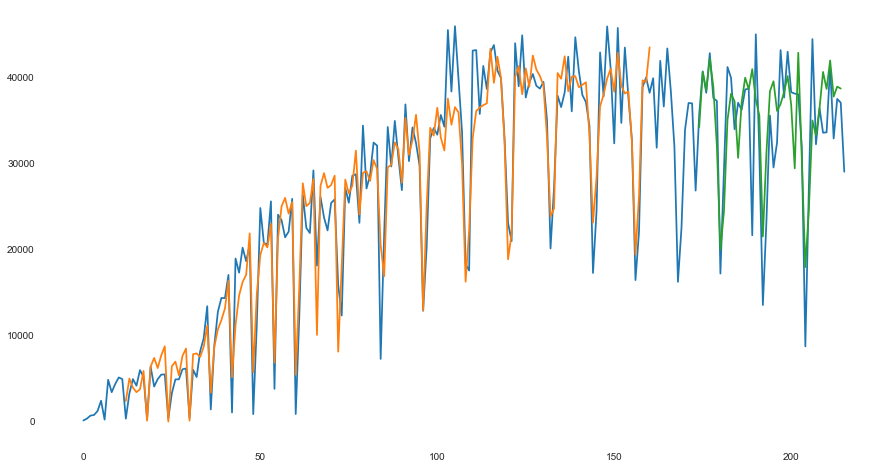

LTSM:                                    5620.094674964016


In [657]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D



# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=12):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

dataframe = dfChoosed[[field]]

dataset = dataframe.values
#dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()

model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print(adjust('LTSM: ',40), forecast_accuracy(testY[0], testPredict[:,0])['rmse'])

In [674]:
train_size = int(len(dataset) * 0.90)
train_size

194

train_size 194
Epoch 1/50
 - 2s - loss: 0.1248
Epoch 2/50
 - 1s - loss: 0.0285
Epoch 3/50
 - 1s - loss: 0.0256
Epoch 4/50
 - 1s - loss: 0.0230
Epoch 5/50
 - 1s - loss: 0.0233
Epoch 6/50
 - 1s - loss: 0.0190
Epoch 7/50
 - 1s - loss: 0.0184
Epoch 8/50
 - 1s - loss: 0.0162
Epoch 9/50
 - 1s - loss: 0.0147
Epoch 10/50
 - 1s - loss: 0.0148
Epoch 11/50
 - 1s - loss: 0.0135
Epoch 12/50
 - 1s - loss: 0.0142
Epoch 13/50
 - 1s - loss: 0.0127
Epoch 14/50
 - 1s - loss: 0.0101
Epoch 15/50
 - 1s - loss: 0.0100
Epoch 16/50
 - 1s - loss: 0.0109
Epoch 17/50
 - 1s - loss: 0.0106
Epoch 18/50
 - 1s - loss: 0.0088
Epoch 19/50
 - 1s - loss: 0.0099
Epoch 20/50
 - 1s - loss: 0.0099
Epoch 21/50
 - 1s - loss: 0.0107
Epoch 22/50
 - 1s - loss: 0.0099
Epoch 23/50
 - 1s - loss: 0.0097
Epoch 24/50
 - 1s - loss: 0.0091
Epoch 25/50
 - 1s - loss: 0.0090
Epoch 26/50
 - 1s - loss: 0.0097
Epoch 27/50
 - 1s - loss: 0.0097
Epoch 28/50
 - 1s - loss: 0.0088
Epoch 29/50
 - 1s - loss: 0.0121
Epoch 30/50
 - 1s - loss: 0.0089
Epoc

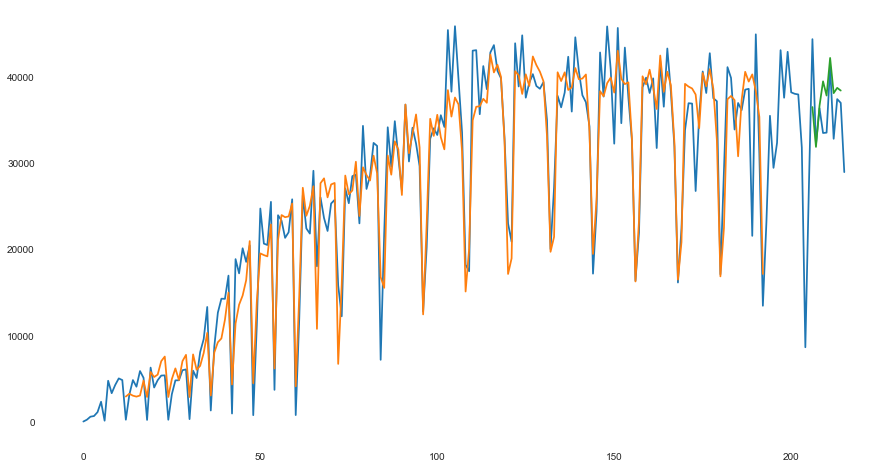

LTSM len:                                9 9
LTSM:                                    4074.839782884698


In [675]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D

numpy.random.seed(7)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=12):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

dataframe = dfChoosed[[field]]

dataset = dataframe.values
#dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset)* 0.90)
print('train_size',train_size)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()

# make predictions LTSM:                                    8354.0303039746
#model.add(LSTM(50, input_shape=(1, look_back)))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
#-----
# make predictions LTSM:                                    8354.0303039746

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, look_back)))
model.add(Dropout(2))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print(adjust('LTSM len: ',40), len(testY[0]), len(testPredict[:,0]))
print(adjust('LTSM: ',40), forecast_accuracy(testY[0], testPredict[:,0])['rmse'])

In [ ]:
testY[0]

194 22
Epoch 1/100
 - 2s - loss: 0.1646
Epoch 2/100
 - 0s - loss: 0.0515
Epoch 3/100
 - 0s - loss: 0.0510
Epoch 4/100
 - 0s - loss: 0.0547
Epoch 5/100
 - 0s - loss: 0.0461
Epoch 6/100
 - 0s - loss: 0.0380
Epoch 7/100
 - 0s - loss: 0.0414
Epoch 8/100
 - 0s - loss: 0.0397
Epoch 9/100
 - 0s - loss: 0.0397
Epoch 10/100
 - 0s - loss: 0.0332
Epoch 11/100
 - 0s - loss: 0.0309
Epoch 12/100
 - 0s - loss: 0.0411
Epoch 13/100
 - 0s - loss: 0.0381
Epoch 14/100
 - 0s - loss: 0.0371
Epoch 15/100
 - 0s - loss: 0.0369
Epoch 16/100
 - 0s - loss: 0.0305
Epoch 17/100
 - 0s - loss: 0.0321
Epoch 18/100
 - 0s - loss: 0.0275
Epoch 19/100
 - 0s - loss: 0.0319
Epoch 20/100
 - 0s - loss: 0.0319
Epoch 21/100
 - 0s - loss: 0.0291
Epoch 22/100
 - 0s - loss: 0.0276
Epoch 23/100
 - 0s - loss: 0.0290
Epoch 24/100
 - 0s - loss: 0.0256
Epoch 25/100
 - 0s - loss: 0.0276
Epoch 26/100
 - 0s - loss: 0.0283
Epoch 27/100
 - 0s - loss: 0.0242
Epoch 28/100
 - 0s - loss: 0.0268
Epoch 29/100
 - 0s - loss: 0.0276
Epoch 30/100
 - 

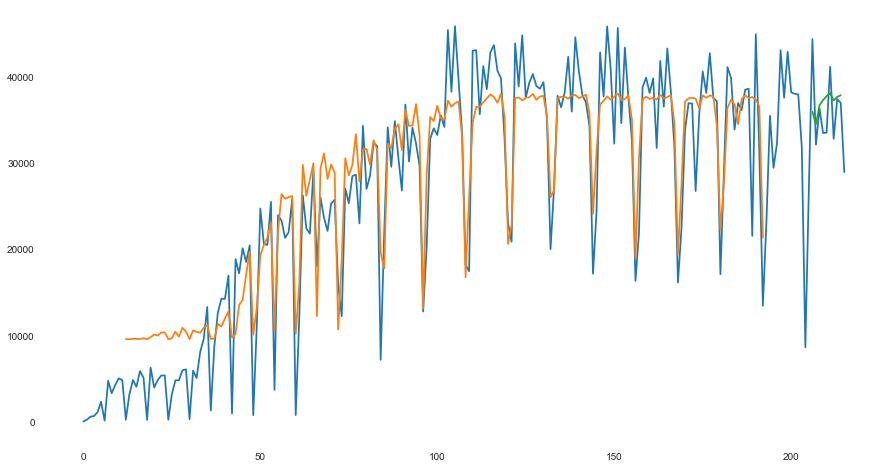

LTSM:                                    3931.688477666301


In [680]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=12):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

dataframe = dfChoosed[[field]]

dataset = dataframe.values
#dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.90)
test_size = len(dataset) - train_size
print(train_size,test_size)
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()

n_features=1 
n_steps = 1
model = Sequential()
model.add(LSTM(15, activation='relu', return_sequences=True, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(LSTM(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print(adjust('LTSM: ',40), forecast_accuracy(testY[0], testPredict[:,0])['rmse'])

In [679]:
testPredict

array([[37853.81 ],
       [34817.01 ],
       [38632.582],
       [38534.96 ],
       [38563.535],
       [41794.81 ],
       [38450.2  ],
       [38997.977],
       [38872.887]], dtype=float32)

In [ ]:
dfPredictLtsm = pd.DataFrame(testPredictPlot)
dfPredictLtsm.index = d[0:len(testPredictPlot)]
dfPredictLtsm.columns = [field]
display(dfPredictLtsm)

In [694]:
look_back

1

Train Score: 3446.44 RMSE
Test Score: 5544.18 RMSE


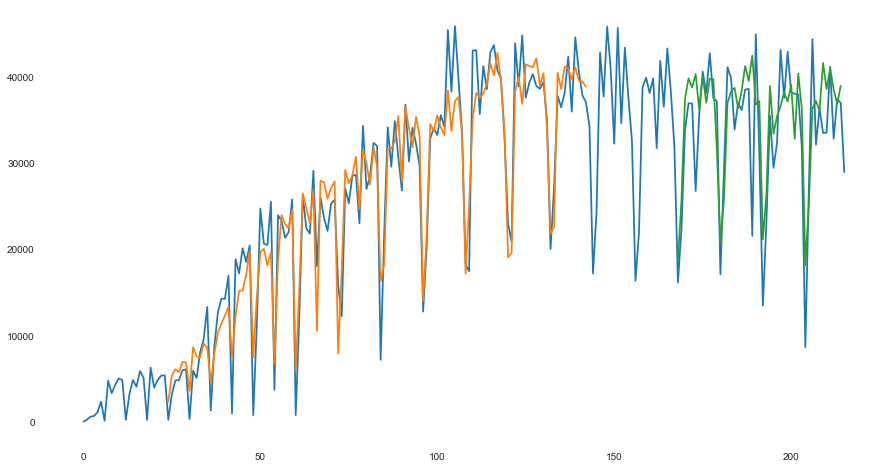

LTSM:                                    5544.17820276307


In [707]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = dfChoosed[[field]]
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=0)
#display(trainX)
#display(trainY)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print(adjust('LTSM: ',40), forecast_accuracy(testY[0], testPredict[:,0])['rmse'])

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

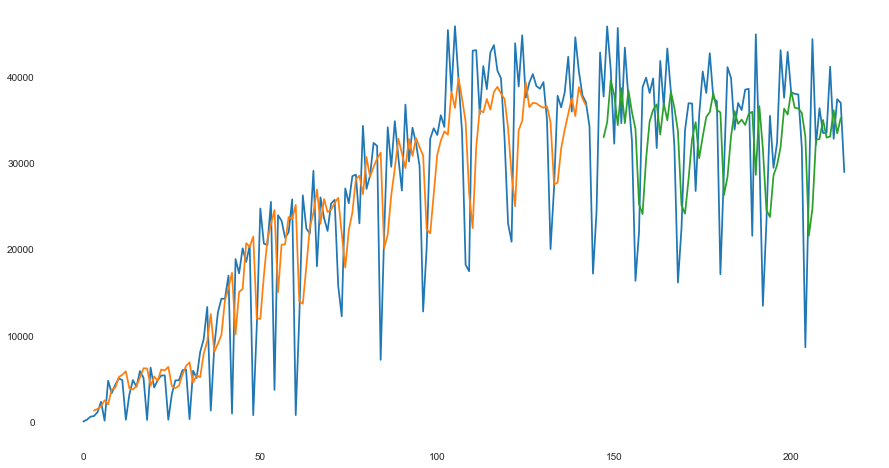

In [706]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = dfChoosed[[field]]
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=3)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# RESUMO

In [92]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=dfChoosed.reset_index()['judgmentDate'], y=dfChoosed[field],mode='lines',name='Real'))
fig.add_trace(go.Scatter(x=dfSimpleExpSmooth.reset_index()['judgmentDate'], y=dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)],mode='lines',name='Exponential Smoothing - DESmul'+str(predictFieldPeriod)))
fig.add_trace(go.Scatter(x=predictions1.index, y=predictions1.values,mode='lines',name='AR Pred'))
fig.add_trace(go.Scatter(x=predictions2.index, y=predictions2.values,mode='lines',name='AR Pred - MaxLag2'))
fig.add_trace(go.Scatter(x=predictions11.index, y=predictions11.values,mode='lines',name='AR Pred (11) - Auto'))
fig.add_trace(go.Scatter(x=fcastAR.index, y=fcastAR.values,mode='lines',name='AR FORECAST'))
#fig.add_trace(go.Scatter(x=predictionsARMA.index, y=predictionsARMA,mode='lines',name='SARIMA')) nao consegue por pois ele foi tornado estacionario
fig.add_trace(go.Scatter(x=fcastARIMANoSeasonal.index, y=fcastARIMANoSeasonal,mode='lines',name='SARIMA FORECAST SEM SAZONALIDADE'))
fig.add_trace(go.Scatter(x=fcastARIMA.index, y=fcastARIMA,mode='lines',name='SARIMA FORECAST'))
fig.add_trace(go.Scatter(x=fcastARIMAExog.index, y=fcastARIMAExog,mode='lines',name='SARIMA FORECAST EXOG'))
fig.add_trace(go.Scatter(x=dfNNetarFC.index, y=dfNNetarFC[field],mode='lines',name='NNETAR'))
fig.add_trace(go.Scatter(x=dfNNetarFCFuture.index, y=dfNNetarFCFuture[field],mode='lines',name='NNETAR FORECAST'))
fig.add_trace(go.Scatter(x=dfETSFC.index, y=dfETSFC[field],mode='lines',name='ETS'))
fig.add_trace(go.Scatter(x=dfTBATS.index, y=dfTBATS[field],mode='lines',name='TBATS'))
fig.add_trace(go.Scatter(x=dfProphetTrain['ds'], y=dfProphetTrain['y'],mode='lines',name='Treino Prophet'))
fig.add_trace(go.Scatter(x=forecastProphet['ds'], y=forecastProphet['yhat'],mode='lines',name='Forecast Prophet'))
fig.add_trace(go.Scatter(x=dfPredictLtsm.index, y=dfPredictLtsm[field],mode='lines',name='LTSM'))


fig.show()



print(adjust("Exponential Smoothing (additional): ",40),forecast_accuracy(dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)][-predictFieldPeriod:],HwForeCastAdd)['rmse'])
print(adjust("Exponential Smoothing (multiplicate): ",40),forecast_accuracy(dfSimpleExpSmooth['DESmul'+str(predictFieldPeriod)][-predictFieldPeriod:],HwForeCastMul)['rmse'])
for i in range(3):
    print(adjust(labelsAR[i]+':',40),forecast_accuracy(arTest[field], ArimaPreds[i])['rmse'])

print(adjust('SARIMAX No Seasonal: ',40),forecast_accuracy(testDiff[field], predictionsARMANoSeasonal)['rmse'])    
print(adjust('SARIMAX: ',40),forecast_accuracy(testDiff[field], predictionsARMA)['rmse'])
print(adjust('SARIMAX Exogenous: ',40),forecast_accuracy(testDiff[field], predictionsARMAExog)['rmse'])
print(adjust('NNETAR: ',40), forecast_accuracy(rdataTest,dfNNetarFC['total'].values)['rmse'])
print(adjust('ETS: ',40), forecast_accuracy(rdataTest,dfETSFC[field].values)['rmse'])
print(adjust('TBATS: ',40), forecast_accuracy(rdataTest,dfTBATS[field].values)['rmse'])
print(adjust('FACEBOOK PROPHET: ',40), forecast_accuracy(dfProphet['y'].values,forecastProphet['yhat'].values)['rmse'])
print(adjust('LTSM: ',40), forecast_accuracy(testY[0],testPredict[:,0])['rmse'])

Exponential Smoothing (additional):      6716.590273332058
Exponential Smoothing (multiplicate):    7365.420027868237
AR(1):                                   11018.575977425984
AR(2):                                   10181.79148359231
AR(14):                                  6184.545540141704
SARIMAX No Seasonal:                     10182.269626958234
SARIMAX:                                 8067.010684513909
SARIMAX Exogenous:                       8416.83357249019
NNETAR:                                  5017.356927115082
ETS:                                     9420.611175424645
TBATS:                                   8426.752907262886
FACEBOOK PROPHET:                        3341.602782603631
LTSM:                                    5315.649403460917
